In [1]:
import os
import csv
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from textwrap import wrap
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering, BaselineOnly, NormalPredictor
from sklearn.preprocessing import MinMaxScaler
from surprise.model_selection import cross_validate, PredefinedKFold, GridSearchCV

In [2]:
#Загрузим данные из файлов. Для начала создадим два датасета - "products" и "transactions", соответственно:

data_dir = './data/recsys/'

PRODUCTS_CSV_PATH = os.path.join(data_dir, 'products.csv')
TRANSACTIONS_CSV_PATH = os.path.join(data_dir, 'transactions.csv')

products = pd.read_csv(PRODUCTS_CSV_PATH)
transactions = pd.read_csv(TRANSACTIONS_CSV_PATH)

# Предварительный анализ данных

## Описание данных

Согласно описанию к заданию, данные состоят из 2 файлов:

* products.csv - товары с их харакретистиками

* transactions.csv - транзакции покупателей

### Файл products.csv
product_id - уникальный идентификатор товара

product_name - название товара

aisle_id - уникальный идентификатор подкатегории

department_id - уникальный идентификатор категории

aisle - название подкатегории

department - название категории

### Файл transactions.csv
order_id - уникальный идентификатор транзакции

user_id - уникальный идентификатор покупателя

order_number - номер транзакции в истории покупок данного пользователя

order_dow - день недели транзакции

order_hour_of_day - час совершения транзакции

days_since_prior_order - количество дней с совершения предыдущей транзакции данным пользователем

product_id - уникальный идентификатор товара

add_to_cart_order - номер под которым данный товар был добавлен в корзину

reordered - был ли товар "перезаказан"

*Проверим, насколько это соответствует правде и, заодно, посмотрим подробную информацию по данных, хранящихся в них.*

In [3]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26408073 entries, 0 to 26408072
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       float64
 8   reordered               float64
dtypes: float64(3), int64(6)
memory usage: 1.8 GB


Похоже, что название столбцов соответствует заявленному. Типы данных также выглядят логичными (соответствуют содержимому). Логично предположить, что связь между датасетами производится через столбец "product_id". Проверим, совпадает ли количество уникальных значений по этому столбцу в двух наборах данных. 

Количество id в таблице с продуктами уже видно выше (49688 уникальных значений), осталось посчитать их количество в таблице транзакций:

In [5]:
transactions.product_id.nunique()

49465

В таблице транзакций представлено немного меньшее количество товаров. У такого явления может быть несколько причин:
* товары совсем новые и их не успели распроовать/купить - в таком случае неплохо бы было их порекомендовать в первую очередь;
* товары уже старые, больше не продаются,но остались в базе продукции - тогда базу продуктов нужно обновить;
* товары настолько непопулярны,плохи или слишком дороги, что их никто не покупает - здесь уже необходима оценка ликвидности продаж товаров, возможно удаление их из продуктовой корзины, переоценка ценовой политики и т.д.

К сожалению, нам не было представлено данных по сроку добавления товара в таблицу продуктов, что не позволяет оценить их новизну для потенциального покупателя и сделать обоснованный вывод по поводу того, что можно, а что нельзя предлагать для покупки. В таком случае самым "безопасным" решением проблемы будет удаление данных товаров из списка рекомендуемых, тем более что таких продуктов не так-то и много. Проще всего это сделать уже на этапе слияния датасетов далее.

In [6]:
# Ради интреса взглянем на эти непокупаемые товары:
not_bought_df = products[~products.product_id.isin(list(transactions.product_id.unique()))]
#Первые 10:
not_bought_df.head(10)

product_id                                       product_name  aisle_id  \
288          289              100% Juice No Sugar Added Fruit Punch        98   
496          497                Mascarpone Pistachio Caramel Gelato        37   
760          761               Tidy Cats 4-in-1 Strength Cat Litter        41   
831          832            High Protein Chocolate Light Milk Shake        65   
1065        1066  Chicken with Noodles Low Sodium Ready To Serve...        69   
1100        1101                                    Seasonal Tamale        30   
1388        1389                   Cranberry Grape 100% Juice Blend        98   
1409        1410            Family Style Pizza Dough, Classic Crust        97   
1907        1908               Greek Blended Cherry Fat Free Yogurt       120   
2082        2083                             Lux German Style Lager        27   

      department_id                      aisle     department  
288               7              juice nectars      beverages  
496               1              ice cream ice         frozen  
760               8              cat food care           pets  
831              11  protein meal replacements  personal care  
1065             15        soup broth bouillon   canned goods  
1100              6               latino foods  international  
1388              7              juice nectars      beverages  
1409             13      baking supplies decor         pantry  
1907             16                     yogurt     dairy eggs  
2082              5              beers coolers        alcohol

In [7]:
#Теперь объединим датафреймы по product_id, исключив ранее обсуждаемые товары:
main = transactions.merge(products, how = 'left')
#Оценим результат:
main.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2539329        1             1          2                  8   
1   2539329        1             1          2                  8   
2   2539329        1             1          2                  8   
3   2539329        1             1          2                  8   
4   2539329        1             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                     NaN         196                1.0        0.0   
1                     NaN       14084                2.0        0.0   
2                     NaN       12427                3.0        0.0   
3                     NaN       26088                4.0        0.0   
4                     NaN       26405                5.0        0.0   

                              product_name  aisle_id  department_id  \
0                                     Soda        77              7   
1  Organic Unsweetened Vanilla Almond Milk        91             16   
2                      Original Beef Jerky        23             19   
3               Aged White Cheddar Popcorn        23             19   
4         XL Pick-A-Size Paper Towel Rolls        54             17   

             aisle  department  
0      soft drinks   beverages  
1  soy lactosefree  dairy eggs  
2    popcorn jerky      snacks  
3    popcorn jerky      snacks  
4      paper goods   household

## Проверка данных на адекватность

<Axes: >

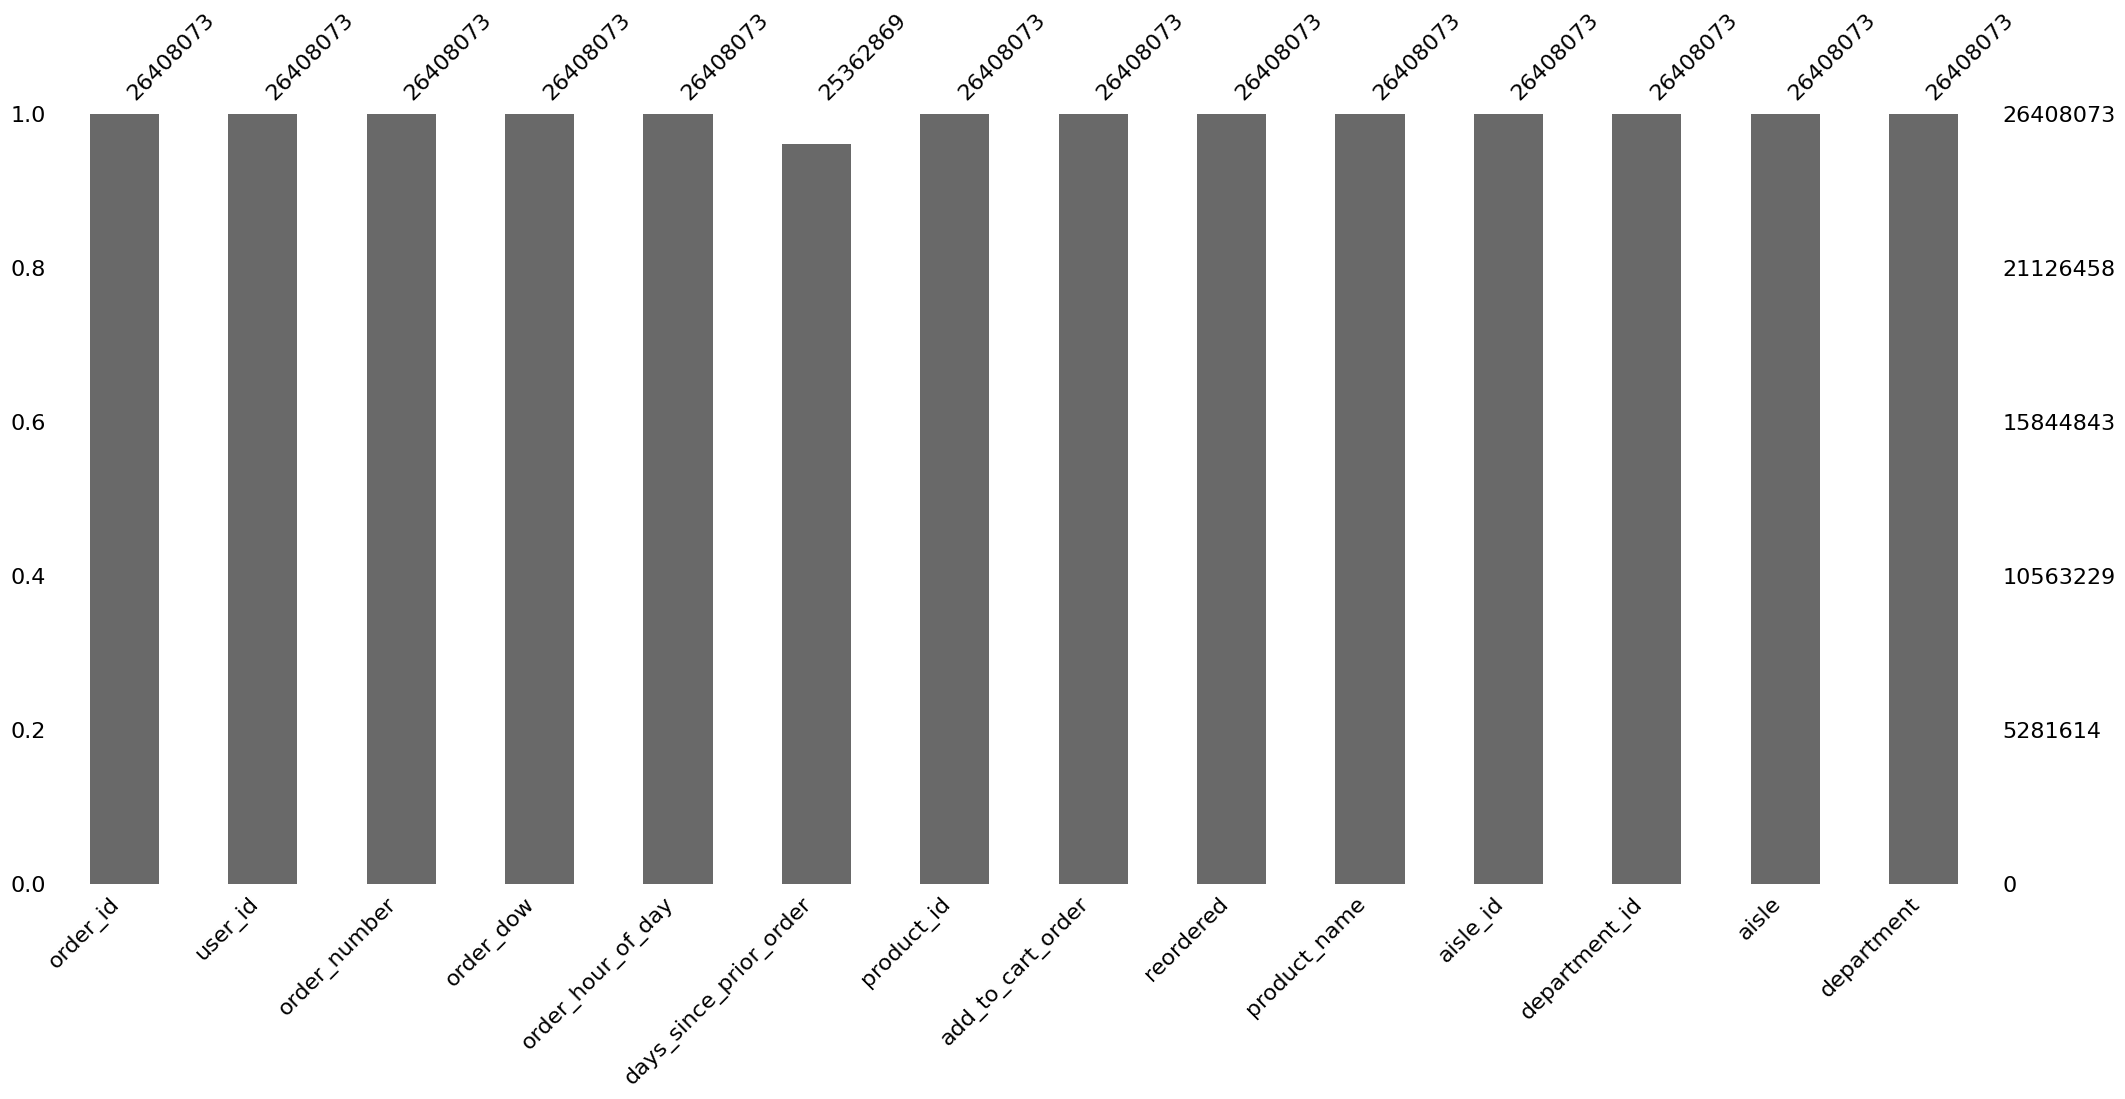

In [8]:
#Проверим датасет на предмет отсутсвующих значений.
msno.bar(main)

*Промежуточный вывод:* Что логично, пустые значения нашлись в столбце "days_since_prior_order" - количество дней с совершения предыдущей транзакции пользователем, т.к. для первой покупки такого значения не будет. Чуть дальше проверим данные по столбцам на логичность.

In [9]:
#Статистика по данным типа object:
main.describe(include = [object])

product_name         aisle department
count      26408073      26408073   26408073
unique        49465           134         21
top          Banana  fresh fruits    produce
freq         391170       3038128    7796052

*Промежуточный вывод:* Помимо уже известного количества продуктов, мы также видим сколько в нашем наборе данных категорий и подкатегорий. Также можно увидеть, что самый часто покупаемый продукт - это бананы, который встречается в транзакциях 391170 раз, самая популярная категория - produce (продукция), самая частая подкатегория - свежие фрукты.

In [10]:
#Посмотрим сколько уникальных значений в каждом числовом столбце датасета:
num_df = main.select_dtypes(include='number')
for k, v in num_df.nunique().to_dict().items():
    print('{} = {}'.format(k,v))

order_id = 2603672
user_id = 100000
order_number = 99
order_dow = 7
order_hour_of_day = 24
days_since_prior_order = 31
product_id = 49465
add_to_cart_order = 145
reordered = 2
aisle_id = 134
department_id = 21


Всего в системе около 2.6 млн.заказов, что гораздо меньше количества строчек транзакций - покупатели редко берут только один продукт, закупки в основной доле крупные. Также мы теперь знаем, что общее количество покупателей равно 100 тыс.
Количественные знаяения id соответствуют количеству названий этих id, что говорит о том, что в данных нет грубых ошибок (пустых категорий, несоответсвия id и названий, дубликатов). Сделаем дополнительную проверку комбинаций id и названий ниже (на всякий).

In [11]:
prod_check = main.groupby(['product_name','product_id']).size().reset_index()
print(prod_check["product_name"].duplicated().any(),prod_check["product_id"].duplicated().any())

False False


In [12]:
aisle_check = main.groupby(['aisle','aisle_id']).size().reset_index()
print(aisle_check["aisle"].duplicated().any(),aisle_check["aisle_id"].duplicated().any())

False False


In [13]:
dep_check = main.groupby(['department','department_id']).size().reset_index()
print(dep_check["department"].duplicated().any(),dep_check["department_id"].duplicated().any())

False False


Замечательно, датасет действительно чистый. Можно переходить к непосредственному изучению данных и построению визуализаций.

## Анализ и визуализация данных

In [14]:
users, products, interactions = main.user_id.nunique(), main.product_id.nunique(), main.shape[0]
 
print('# users: ', users)
print('# products: ', products)
print('# interactions: ', interactions)

# users:  100000
# products:  49465
# interactions:  26408073


Пойдем по порядку следования колонок в столбце. Посмотрим наибольшее и наименьшее количество заказов пользователей.

In [15]:
ordered_users = main.groupby(['user_id'], as_index=False)['order_number'].max()
ordered = ordered_users['order_number'].value_counts().to_frame(name="users_cnt")
ordered = ordered.reset_index()
print(' Минимальное количество заказов: ', ordered.order_number.min(), '\n' ,'Максимальное количество заказов: ',
      ordered.order_number.max())

 Минимальное количество заказов:  9 
 Максимальное количество заказов:  99


In [16]:
#Соберем пользователей в группы для визуализации:
def group_users(x):
    if x < 12:
        y = '<12'
    elif 12 <= x <= 15:
        y = '12-15'     
    elif 15 < x <= 25:
        y = '16-25'     
    elif 25 < x <= 40:
        y = '26-40'
    elif 40 < x <= 55:
        y = '41-55'
    else:
        y = '>55'
    return y
ordered['users_group'] = ordered['order_number'].apply(group_users)
ordered = ordered[["users_cnt","users_group"]].groupby(['users_group'])['users_cnt'].sum()
ordered = ordered.reindex(['<12','12-15','16-25','26-40','41-55','>55']).reset_index()

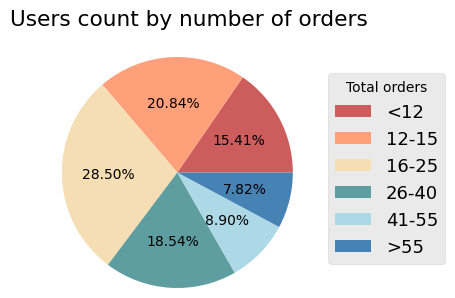

In [17]:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(ordered.users_cnt, autopct='%1.2f%%', labeldistance=1.1, radius=1.25, \
                                  colors = ['indianred','lightsalmon','wheat','cadetblue','lightblue','steelblue'])
    ax.set_title('Users count by number of orders', x=0.55, y=1.1)
    ax.legend(wedges,
              ordered.users_group,
              title="Total orders",
              bbox_to_anchor=(1.2, 0.22, 0.5, 0.75))
plt.show()

*Промежуточный вывод:* На круговой диаграмме четко выделяются группы пользователей с общим количеством заказов от 12 до 25 (вместе эта группа составляет чуть менее 50% от общего числа пользователей). Дальше наблюдается четкая тенденция к снижению с увеличением количества заказов. Наименьшая группа клиентов (менее 8%) воспользовалась сервисом заказа более 55 раз. До двенадцати заказов при этом приходится на 15% от общего числа пользователей, т.е. почти 85% клиентов совершило болшее количество покупок.

In [18]:
# Посчитаем к-во полдьзователей в разрезе числа дней с прошлой покупки:
order_days = main.groupby(['user_id'], as_index=False)['days_since_prior_order'].last()
order_days = order_days['days_since_prior_order'].value_counts().to_frame(name="users_cnt")
order_days = order_days.reset_index()
order_days = order_days.sort_values(by = 'days_since_prior_order')

In [19]:
order_days

days_since_prior_order  users_cnt
17                     0.0       1765
11                     1.0       3085
7                      2.0       4173
6                      3.0       4884
5                      4.0       5316
4                      5.0       5602
2                      6.0       6608
1                      7.0       9734
3                      8.0       5825
9                      9.0       3912
10                    10.0       3230
13                    11.0       2821
14                    12.0       2759
12                    13.0       3047
8                     14.0       3948
15                    15.0       2549
18                    16.0       1751
20                    17.0       1571
21                    18.0       1479
22                    19.0       1406
19                    20.0       1609
16                    21.0       1931
23                    22.0       1312
25                    23.0       1033
27                    24.0        867
28                    25.0        827
29                    26.0        796
26                    27.0        868
24                    28.0       1106
30                    29.0        765
0                     30.0      13421

In [20]:
#Разобъем на группы для визуализации:
def group_users_days(x):
    if x < 5:
        y = '<=5'
    elif 5 < x <= 10:
        y = '6-10'
    elif 11 < x <= 15:
        y = '11-15'
    elif 15 < x <= 20:
        y = '16-20'
    elif 20 < x <= 29:
        y = '21-29'
    else:
        y = '30'
    return y

order_days['days_group'] = order_days['days_since_prior_order'].apply(group_users_days)
order_days = order_days[["users_cnt","days_group"]].groupby(['days_group'], as_index=False)['users_cnt'].sum()

In [21]:
#Посмотрим что получилось:
order_days

days_group  users_cnt
0      11-15      12303
1      16-20       7816
2      21-29       9505
3         30      21844
4       6-10      29309
5        <=5      19223

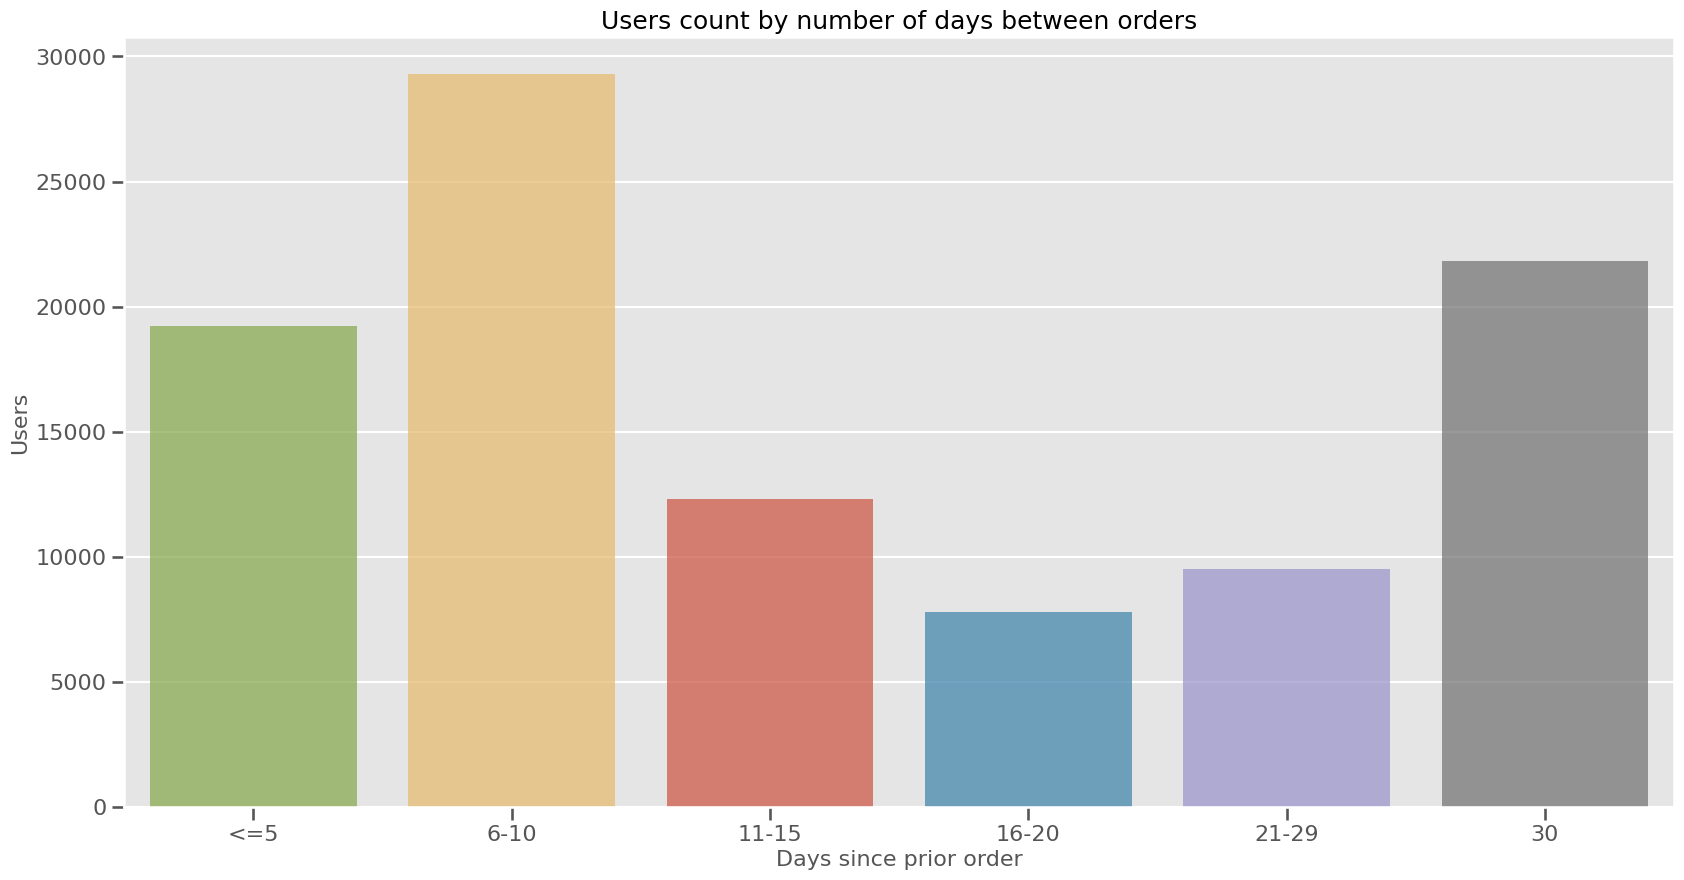

In [22]:
#Построим barplot:
with plt.style.context(['ggplot']):
    plt.figure(figsize=(20,10))
    sns.set_context("talk", rc={"lines.linewidth": 1.5, "font.size":16,"axes.titlesize":18,"axes.labelsize":16})
    b = sns.barplot(order_days, y=order_days.users_cnt, x=order_days.days_group, alpha=0.75, \
            order = ['<=5','6-10','11-15','16-20','21-29','30'], hue = order_days.days_group)
    b.axes.set_title("Users count by number of days between orders", fontsize=18)
    b.set_xlabel("Days since prior order",fontsize=16)
    b.set_ylabel("Users",fontsize=16)
#     ticks = np.arange(0, 30, 1)
#     b.set_yticks(ticks)
#     b.set_yticklabels(ticks)
    b.tick_params(labelsize=16)
plt.show()

*Промежуточный вывод:* В распределении преобладают пользователи, которые сделали заказ от 6 до 10 дней назад. Меньше всего тех, для кого между заказами прошло от 16 до 20 дней. При этом достаточно выделяется группа пользователей (>20 тыс), которая сделала заказ 30 дней назад. Интересно,означает ли это, что эта группа людей перестала пользоваться сервисом? Проверим это, сверив медиану срока их покупок. Логика такая: если эти пользователи закупаются в среднем сравнительно редко, то скорее всего они будут пользоваться сервисом далее. Если нет - скорее всего они уже не являются активными пользователями.

In [23]:
order_days = main.groupby(['user_id'], as_index=False)['days_since_prior_order'].last()
#Возьмем пользователей с даты последней покупки которых прошло 30 дней:
u_list = list(order_days.user_id[order_days.days_since_prior_order ==30])
max_order_days = main[main['user_id'].isin(u_list)].groupby(['user_id'], as_index=False)['days_since_prior_order'].median()

In [24]:
# Выведем результат на круговой диаграмме:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    data = [len(max_order_days[max_order_days['days_since_prior_order']>=20]), len(max_order_days[max_order_days["days_since_prior_order"]<20])]
    lbs = ['yes','no']
    explode = (0.2, 0)
    wedges, texts, autotexts = ax.pie(data, autopct='%1.2f%%', explode = explode, labeldistance=1.1, radius=1.25, \
                                  colors = ['salmon','lightblue'])
    ax.legend(wedges,
              lbs,
              title="Rare buyer?",
              bbox_to_anchor=(1.1, 0.2, 0.5, 0.75))
plt.show()

*Промежуточный вывод:* Диаграмма показывает возможность наличия достаточно большой группы пользователей, которая перстала пользоваться сервисом. При этом есть также группа которая в целом достаточно редко осуществляет закупки. Интересно, есть ли различия по количеству купленных товаров у таких пользователей по сравнению с теми, кто закупается часто?

In [25]:

#Найдем медианные значения к-ва дней с предыдущей покупки и к-ва купленных товаров для каждого пользователея:
agg_func_math = {
    'days_since_prior_order': ['median'],
    'add_to_cart_order': ['median'],    
}
#Сначала найдем сколько товаров куплено пользователем в рамках каждого заказа (макс по "add_to_cart_order"), 
#затем найдем медианы к-ва дней и к-ва товаров для каждого пользователя по всем его заказам
ord_days = main.groupby(['user_id','order_number','days_since_prior_order'])['add_to_cart_order']\
    .max()\
    .reset_index()\
    .groupby(['user_id'], as_index=False).agg(agg_func_math)

# Сбросим мульти индекс в столбцах:
ord_days.columns =  ord_days.columns.get_level_values(0)

#Объединим в группы по к-ву дней по аналогии с примером выше:
ord_days['days_group'] = ord_days['days_since_prior_order'].apply(group_users_days)
#И снова найдем медиану покупок:
ord_days = ord_days.groupby(['days_group'], as_index=False)['add_to_cart_order'].median()

In [26]:
ord_days

days_group  add_to_cart_order
0      11-15                9.0
1      16-20                8.5
2      21-29                8.0
3         30                8.0
4       6-10                9.0
5        <=5                7.0

 *Промежуточный вывод:* Различий между группами не наблюдается, что также может указывать на то, что пользователи слишком редко пользующиеся сервисом забросили его окончательно. 
 А отличается ли всё-таки от других по признаку к-ва товара в заказе группа действительно редко покупающих? Попробуем из набора данных выделить эту группу.

In [27]:
#Сузим список пользователей до тех, у кого с даты последней покупки прошло 30 дней и медиана дней по всем заказам больше 20:
u_list_20 = list(max_order_days[max_order_days['days_since_prior_order']>=20].user_id)
rare_buyers = main[main['user_id'].isin(u_list_20)].groupby(['user_id'], as_index=False)['add_to_cart_order'].median()
#Выведем уникальные значения по полю к-во товаров из набора данных для проверки:
rare_buyers['add_to_cart_order'].unique()

array([ 3. ,  9. , 18.5,  1. ,  5. ,  2. ,  7. , 11. ,  4. , 10. ,  8. ,
       15.5,  4.5, 19. ,  9.5, 21. ,  6. ,  3.5, 12. , 14. , 13.5, 13. ,
       23. ,  1.5, 12.5, 15. ,  7.5,  6.5, 16. ,  5.5,  2.5, 11.5, 18. ,
       25. , 20. , 10.5,  8.5, 17. , 26. , 14.5])

In [28]:
#Видно, что есть пользователи с достаточно весомыми покупками. Посмотрим сколько их.
rare_buyers = rare_buyers['add_to_cart_order'].value_counts().to_frame(name="users_cnt")
def group_users_rare(x):
    if x <= 10:
        y = '<=10'
    elif 11 < x <= 20:
        y = '11-20'
    elif 21 < x <= 25:
        y = '21-25'  
    else:
        y = '>25'
    return y

rare_buyers['order_group'] = rare_buyers['users_cnt'].apply(group_users_rare)
rare_buyers = rare_buyers[["users_cnt","order_group"]].groupby(['order_group'], as_index=False)['users_cnt'].sum()
rare_buyers

order_group  users_cnt
0       11-20         80
1       21-25         49
2        <=10         45
3         >25       3623

 *Промежуточный вывод:* Группа редко покупающих, судя по наличию большого количества покупателей с крупными заказами, действительно существует, хотя их не так много.

Интересно так же изучить состав корзины покупателей. Последовательно изучим покупки по категориям, подкатегориям и по продуктам.

In [29]:
# Посмотрим к-во покупок в разрезе категорий товаров:
deps = main['department'].value_counts().to_frame(name="orders_by_dept")
deps = deps.reset_index()
#Поделим на миллион для удобства отображения на графике:
deps['orders_by_dept_mln'] = deps.orders_by_dept/1e6

In [30]:
#Построим столбчатую диаграмму:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    plt.figure(figsize=(20,10))
    plt.title("Number of orders by product department", fontsize=18)
    plt.tick_params(labelsize=16)
    b = sns.barplot(y=deps.department, x=deps.orders_by_dept_mln, hue = deps.department)
    b.set_xlabel("Orders, mln",fontsize=16)
    b.set_ylabel("Department",fontsize=16)
plt.show()

In [31]:
#Интересно, что это за 'missing'dept?
main[main['department'] == 'missing']

order_id  user_id  order_number  order_dow  order_hour_of_day  \
592        1757094       13             8          6                 18   
594         519471       13             9          6                 17   
605        2298068       13            10          6                 22   
610        1472646       13            11          0                 14   
620        1789302       13            12          6                 13   
...            ...      ...           ...        ...                ...   
26406044    675296   206200            12          6                 13   
26406054   1875862   206200            13          3                 14   
26406586    584166   206201            30          0                  7   
26407588   3128968   206208            23          5                 16   
26407861   2675140   206208            42          1                 19   

          days_since_prior_order  product_id  add_to_cart_order  reordered  \
592                         13.0       25134                5.0        0.0   
594                          7.0       25134                2.0        1.0   
605                          7.0       25134                8.0        1.0   
610                          8.0       25134                4.0        1.0   
620                          6.0       41926                6.0        0.0   
...                          ...         ...                ...        ...   
26406044                     1.0       11494                6.0        1.0   
26406054                     4.0        7035                3.0        0.0   
26406586                    24.0       33935               25.0        0.0   
26407588                     4.0       41870               17.0        0.0   
26407861                     6.0       48865                7.0        0.0   

                                               product_name  aisle_id  \
592                                          Cilantro Bunch       100   
594                                          Cilantro Bunch       100   
605                                          Cilantro Bunch       100   
610                                          Cilantro Bunch       100   
620                              Whole Grain Thin Spaghetti       100   
...                                                     ...       ...   
26406044              Cookie Dough Ice Cream Chocolate Chip       100   
26406054                        Peanut Butter Ice Cream Cup       100   
26406586  Double Stuf Chocolate/Chocolate Variety Pack S...       100   
26407588                           Mexican Chocolate Yogurt       100   
26407861                             Organic Ground Chicken       100   

          department_id    aisle department  
592                  21  missing    missing  
594                  21  missing    missing  
605                  21  missing    missing  
610                  21  missing    missing  
620                  21  missing    missing  
...                 ...      ...        ...  
26406044             21  missing    missing  
26406054             21  missing    missing  
26406586             21  missing    missing  
26407588             21  missing    missing  
26407861             21  missing    missing  

[51481 rows x 14 columns]

Занятно, есть ряд продуктов, которые по какой-то причине забыли отнести к какой-либо категории. На нашу работу это не должно повлиять, но посмотреть сколько таких "ошибок" тоже интересно...

In [32]:
#К-во продуктов с отсутсвующей информацией:
len(main.product_id[main['department'] == 'missing'].unique())

1211

Для компании наличие таких позиций не особо благоприятно, т.к.скорее всего пользователь попросту не сможет найти их на сайте, не используя поисковик и точный поисковой запрос позиции, что делают далеко не все покупатели. Многим удобнее искать продукты в списке категорий (например, зайти в категорию "Молоко", посмотреть список всех позиций и выбрать понравившееся). В итоге мы получаем более 1000 позиций, которые не покупают, потому что они попросту не отображаются в определенной категории товаров. Если, конечно, это не позиции к удалению или какая-то отдельная акционная категория товаров, о чем мы узнать из наших данных не сможем.

In [33]:
#А что в 'other'dept?
main[main['department'] == 'other']

order_id  user_id  order_number  order_dow  order_hour_of_day  \
648        1385564       14             4          6                  8   
654        1385564       14             4          6                  8   
678        1691859       14             5          5                  8   
689        2127409       14             6          1                  8   
720        2505309       14             7          5                 10   
...            ...      ...           ...        ...                ...   
26402052   1302687   206160             6          3                 14   
26402063   3028988   206160             7          3                  0   
26402762    360804   206165            20          4                 16   
26405106   1768654   206193            26          2                 15   
26407040   2475308   206206            58          0                 15   

          days_since_prior_order  product_id  add_to_cart_order  reordered  \
648                         20.0       16776               13.0        0.0   
654                         20.0       32115               19.0        0.0   
678                         30.0       32115               16.0        1.0   
689                         30.0       16776                4.0        1.0   
720                         30.0       16776                7.0        1.0   
...                          ...         ...                ...        ...   
26402052                    30.0       24316                6.0        1.0   
26402063                    21.0       38412                3.0        0.0   
26402762                    22.0       13862               17.0        0.0   
26405106                     2.0        4928                3.0        0.0   
26407040                     0.0       45573                3.0        0.0   

                                       product_name  aisle_id  department_id  \
648                                   Crushed Chili         6              2   
654                                93/7 Ground Beef         6              2   
678                                93/7 Ground Beef         6              2   
689                                   Crushed Chili         6              2   
720                                   Crushed Chili         6              2   
...                                             ...       ...            ...   
26402052                                Raw Walnuts         6              2   
26402063                        Pitted Green Olives         6              2   
26402762  Maximum Absorbency XL for Women Underwear         6              2   
26405106                           Black Chia Seeds         6              2   
26407040                      Strike On Box Matches         6              2   

          aisle department  
648       other      other  
654       other      other  
678       other      other  
689       other      other  
720       other      other  
...         ...        ...  
26402052  other      other  
26402063  other      other  
26402762  other      other  
26405106  other      other  
26407040  other      other  

[28739 rows x 14 columns]

In [34]:
#К-во продуктов в "other":
len(main.product_id[main['department'] == 'other'].unique())

546

In [35]:
#Глянем список:
list(main.product_name[main['department'] == 'other'].unique())

['Crushed Chili',
 '93/7 Ground Beef',
 'Whole Bay Leaves',
 'Raw Walnuts',
 'Organic Whole Wheat Couscous',
 '3mg Melatonin Dietary Supplement Tablets - 240 CT',
 'Deluxe Nut Mix',
 'Traditional Panettone',
 'PM Simply Sleep Nighttime Sleep Aid Caplets',
 'Cherry Nighttime Instant Teething Pain Relief Gel',
 'Melatonin TR, Time Release, 1 mg, Tablets',
 'Original Pickle',
 'Facial Tissues with Lotion',
 'Peppermint Essential Oil',
 'Light CocoWhip! Coconut Whipped Topping',
 'Roasted Salted Pistachios',
 'Walnuts',
 'PM Pain Reliever and Nighttime Sleep Aid Caplets',
 'Roasted Almond Butter',
 'BabyRub® Soothing Ointment',
 'Rapid Relief Creamy Diaper Rash Ointment',
 'Coconut Flour',
 'Quick Dry White Correction Fluid',
 'Organic Garam Masala',
 'Sunflower Seeds',
 'Coffee Mate French Vanilla Creamer Packets',
 'Hazelnut Liquid Coffee Creamer',
 'Cinnamon Vanilla Creme Liquid Coffee Creamer',
 'Classic Vanilla Coffee Creamer',
 'Sweets Organic Lollipops',
 'Her Pleasure Ecstasy Ultra

*Промежуточный вывод:* В этом списке много всяких аптечных позиций, БАДов, но при этом в первых строках видно и откровенно пищевую продукцию - Beef, Chilli, Couscous, Walnuts и т.д. Компании надо серьезно продумать и пересмотреть свою систему маркировки. Встречаются откровенные ошибки. Большое количество подобных ошибок может негативно повлиять как на работу системы рекомендаций, так и на покупки пользователей.

In [36]:
# Посмотрим то же,но в разрезе подкатегорий товаров:
aisles = main['aisle'].value_counts().to_frame(name="orders_by_aisle")
aisles = aisles.reset_index()
#Поделим на тысячу для удобства отображения на графике:
aisles['orders_by_aisle_ths'] = aisles.orders_by_aisle/1000

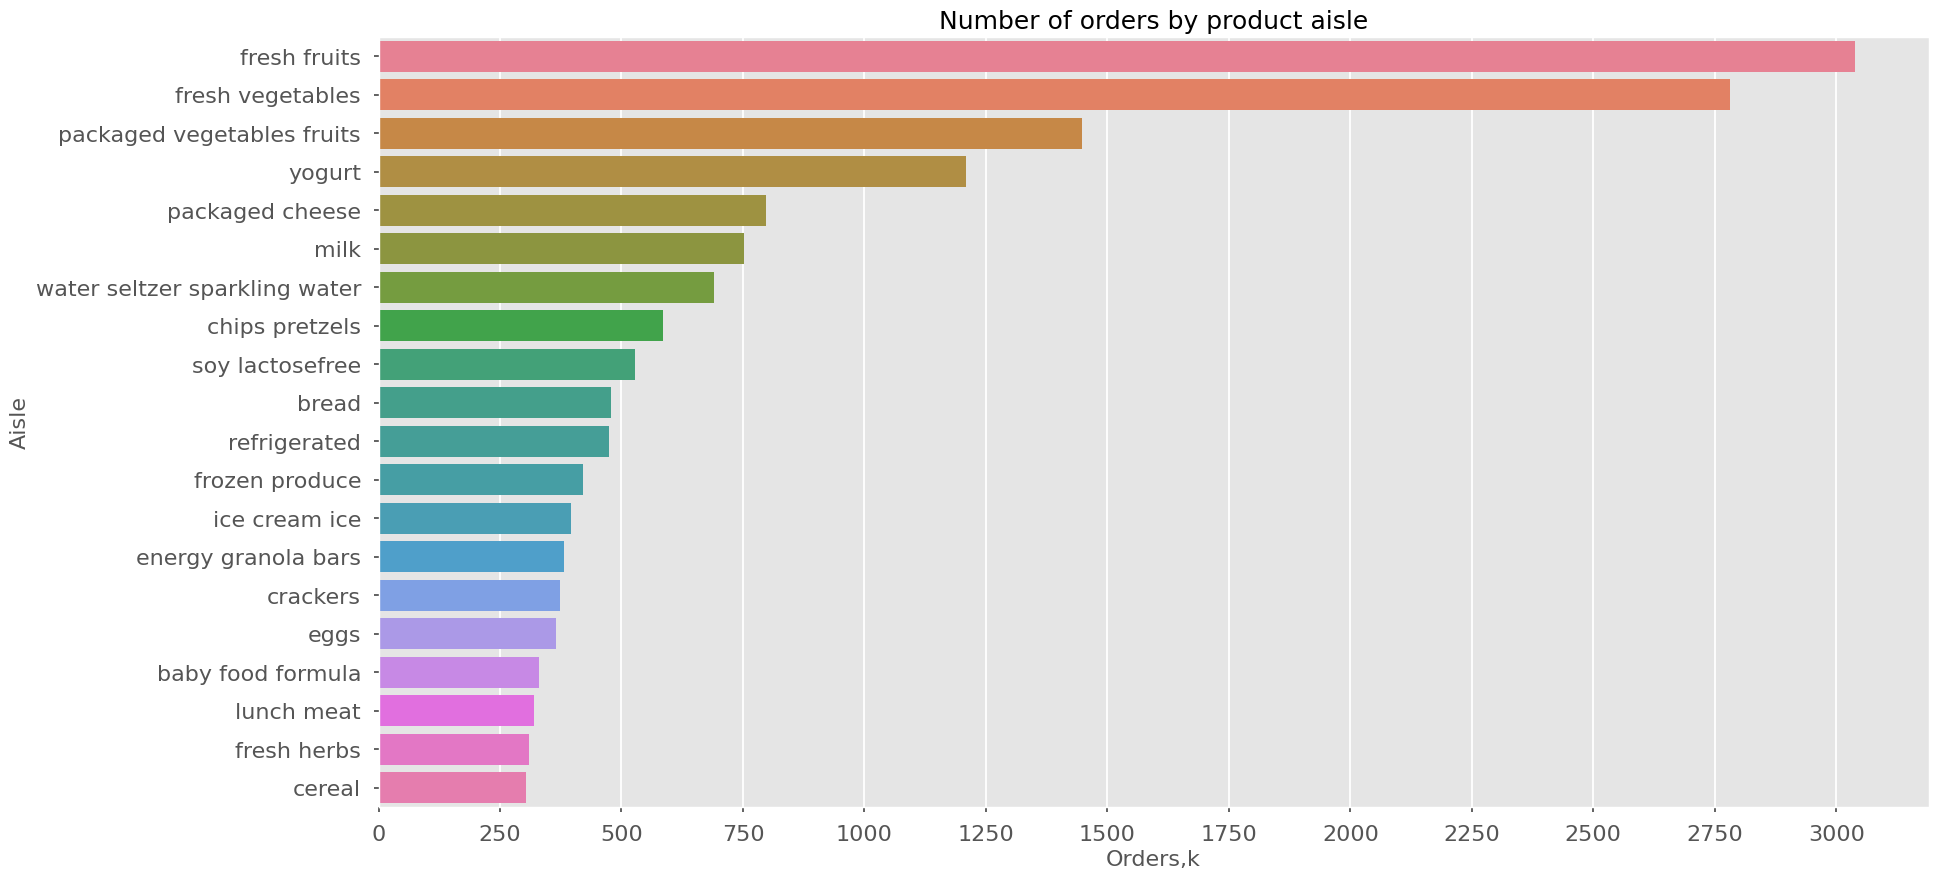

In [37]:
#Мы можем вывести на график первые 20 по популярности позиций:
aisles_max = aisles[:20]
#Аналогично, создадим диаграмму:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    plt.figure(figsize=(20,10))
    plt.title("Number of orders by product aisle", fontsize=18)
    plt.tick_params(labelsize=16)
    b = sns.barplot(y=aisles_max.aisle, x=aisles_max.orders_by_aisle_ths, hue = aisles_max.aisle)
    b.set_xlabel("Orders,k",fontsize=16)
    b.set_ylabel("Aisle",fontsize=16)
    ticks = np.arange(0, 3250, 250)
    b.set_xticks(ticks)
    b.set_xticklabels(ticks)
plt.show()

In [38]:
#И, наконец, соберем самые популярные продукты:
prods = main['product_name'].value_counts().to_frame(name="orders_by_prod")
prods = prods.reset_index()
#Поделим на тысячу для удобства отображения на графике:
prods['orders_by_prod_ths'] = prods.orders_by_prod/1000

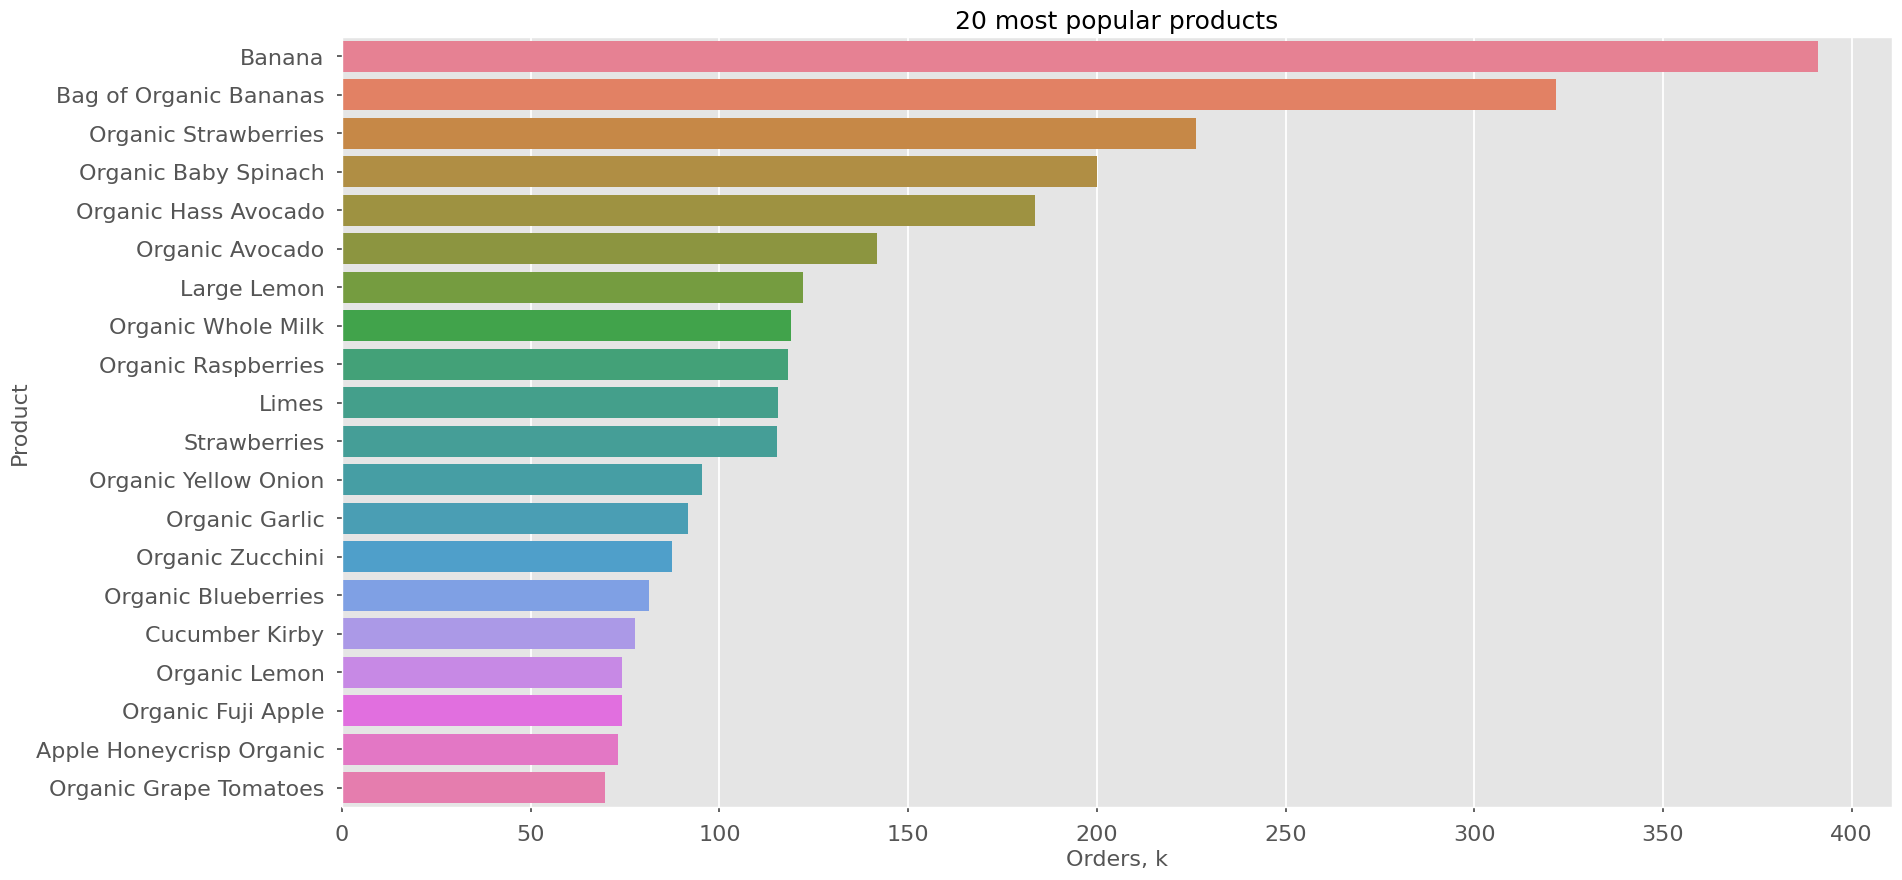

In [39]:
#Выявим первые 20 по популярности позиций:
prods_max = prods[:20]
#Построим диаграмму:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    plt.figure(figsize=(20,10))
    plt.title("20 most popular products", fontsize=18)
    plt.tick_params(labelsize=16)
    b = sns.barplot(y=prods_max.product_name, x=prods_max.orders_by_prod_ths, hue = prods_max.product_name)
    b.set_xlabel("Orders, k",fontsize=16)
    b.set_ylabel("Product",fontsize=16)
plt.show()

Дополнительно ради интереса выведем по 10 популярных продуктов из 10 самых популярных подкатегорий.

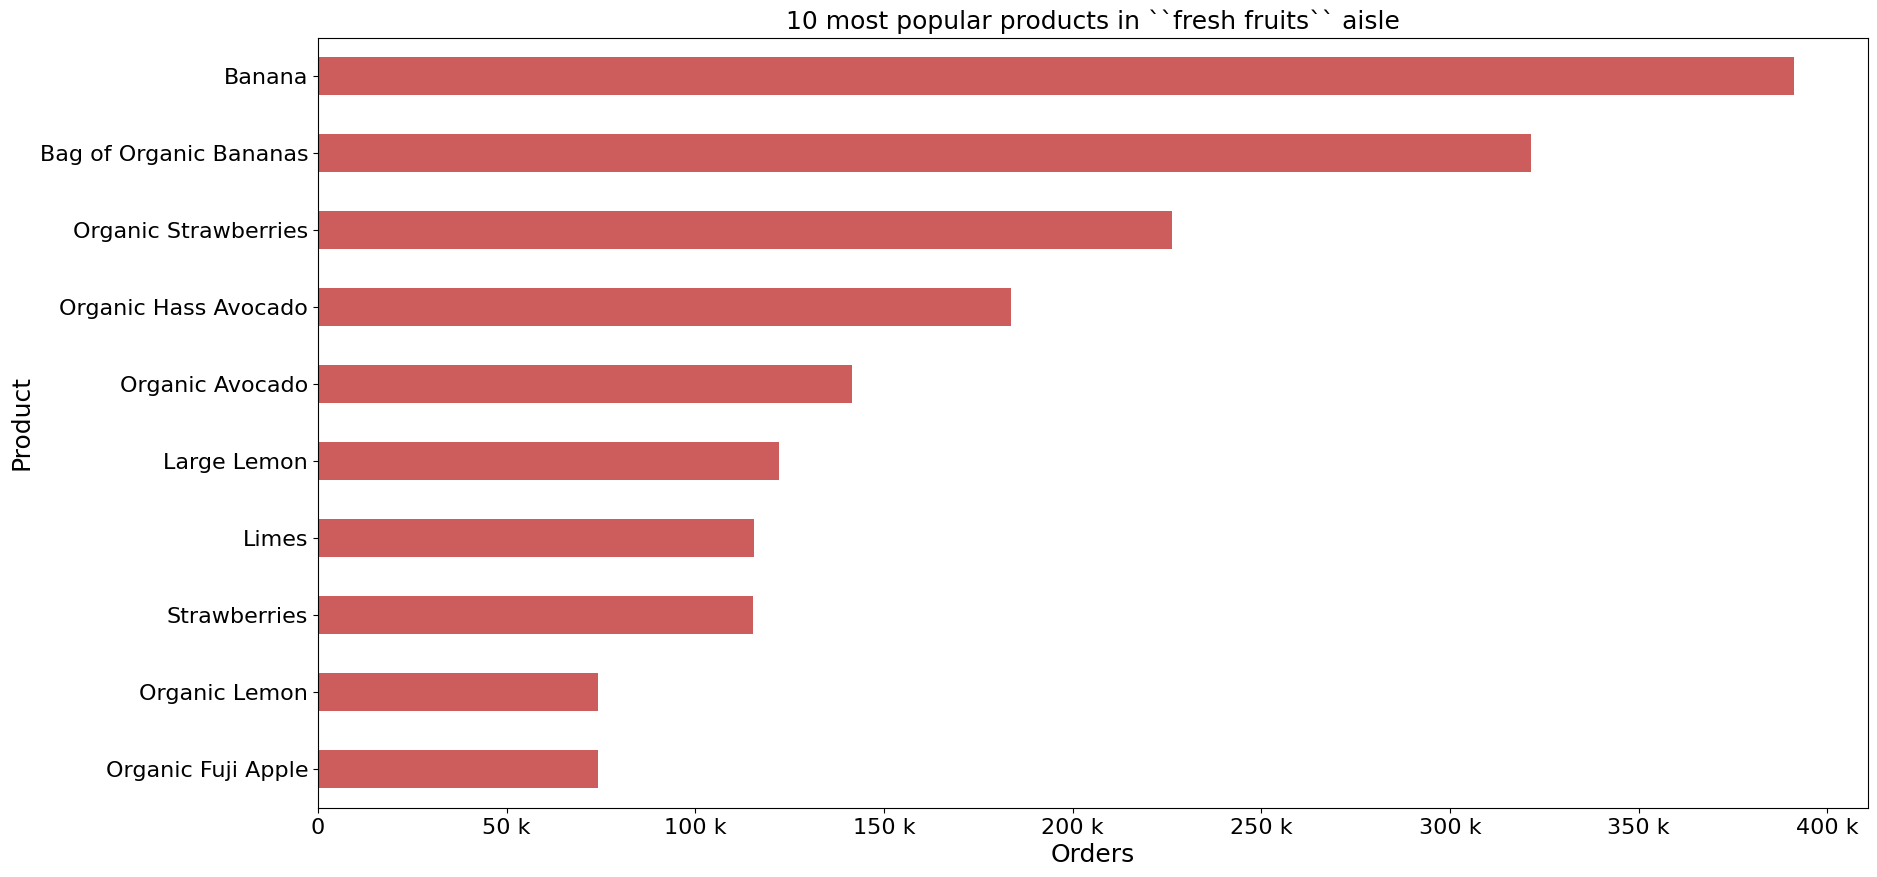

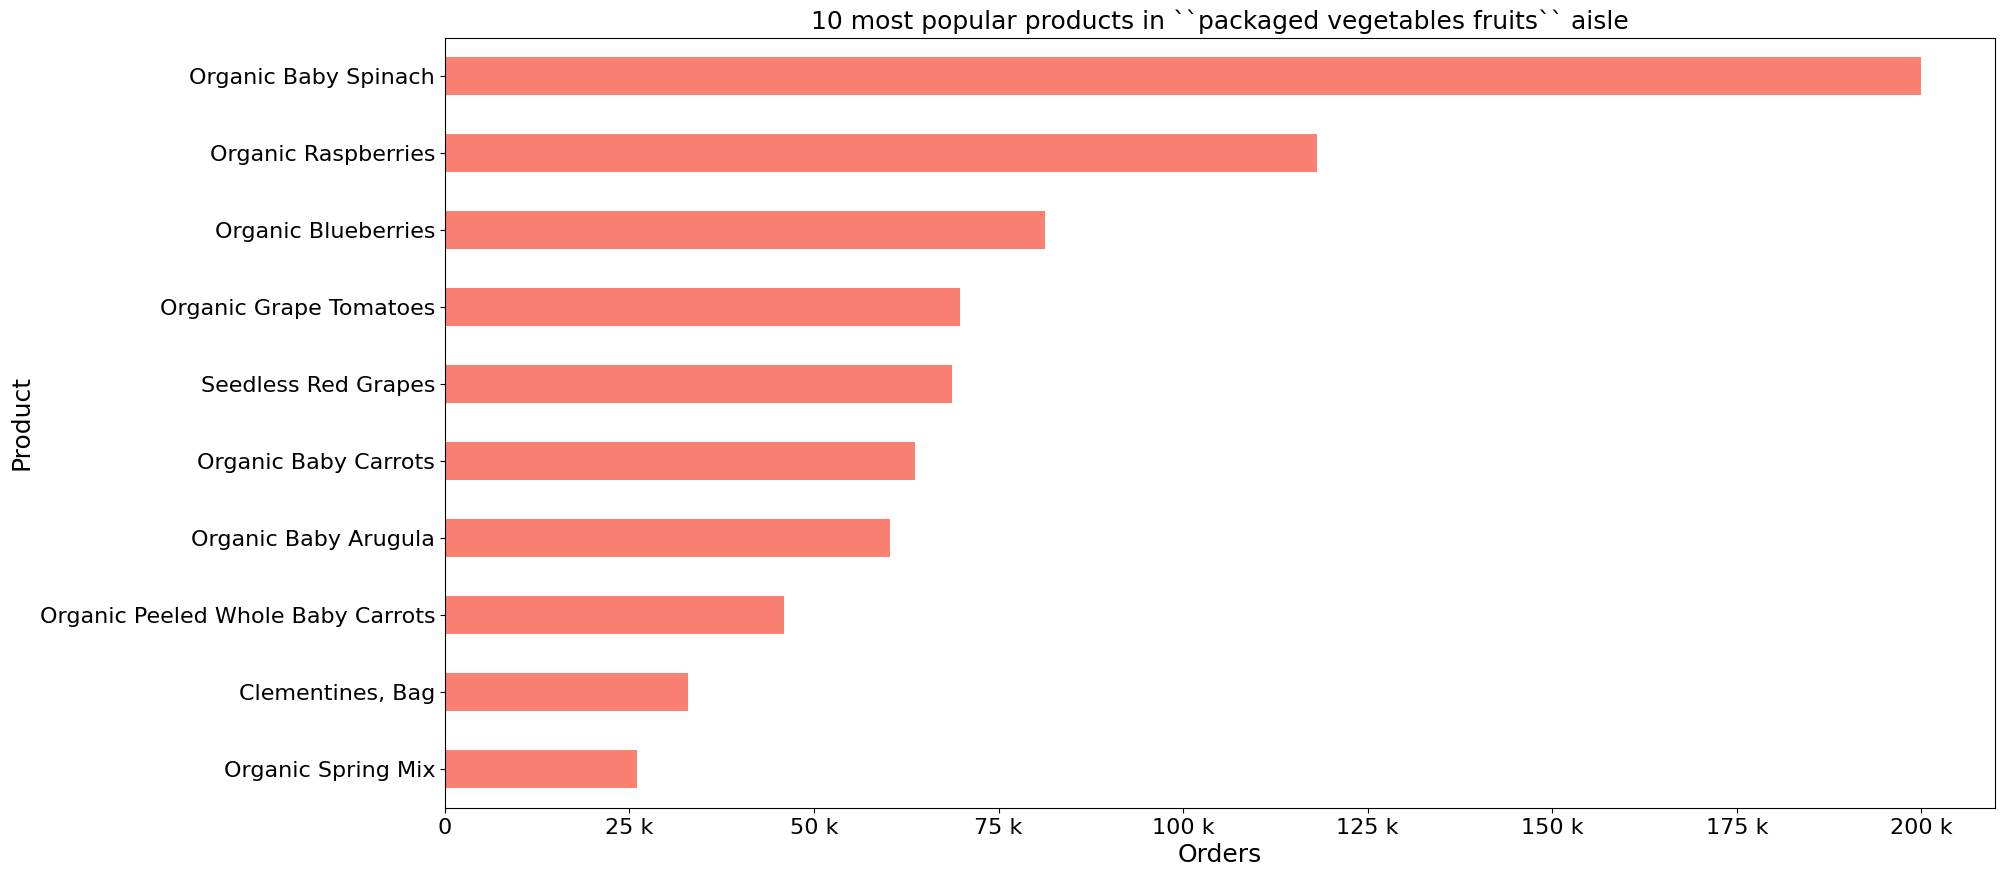

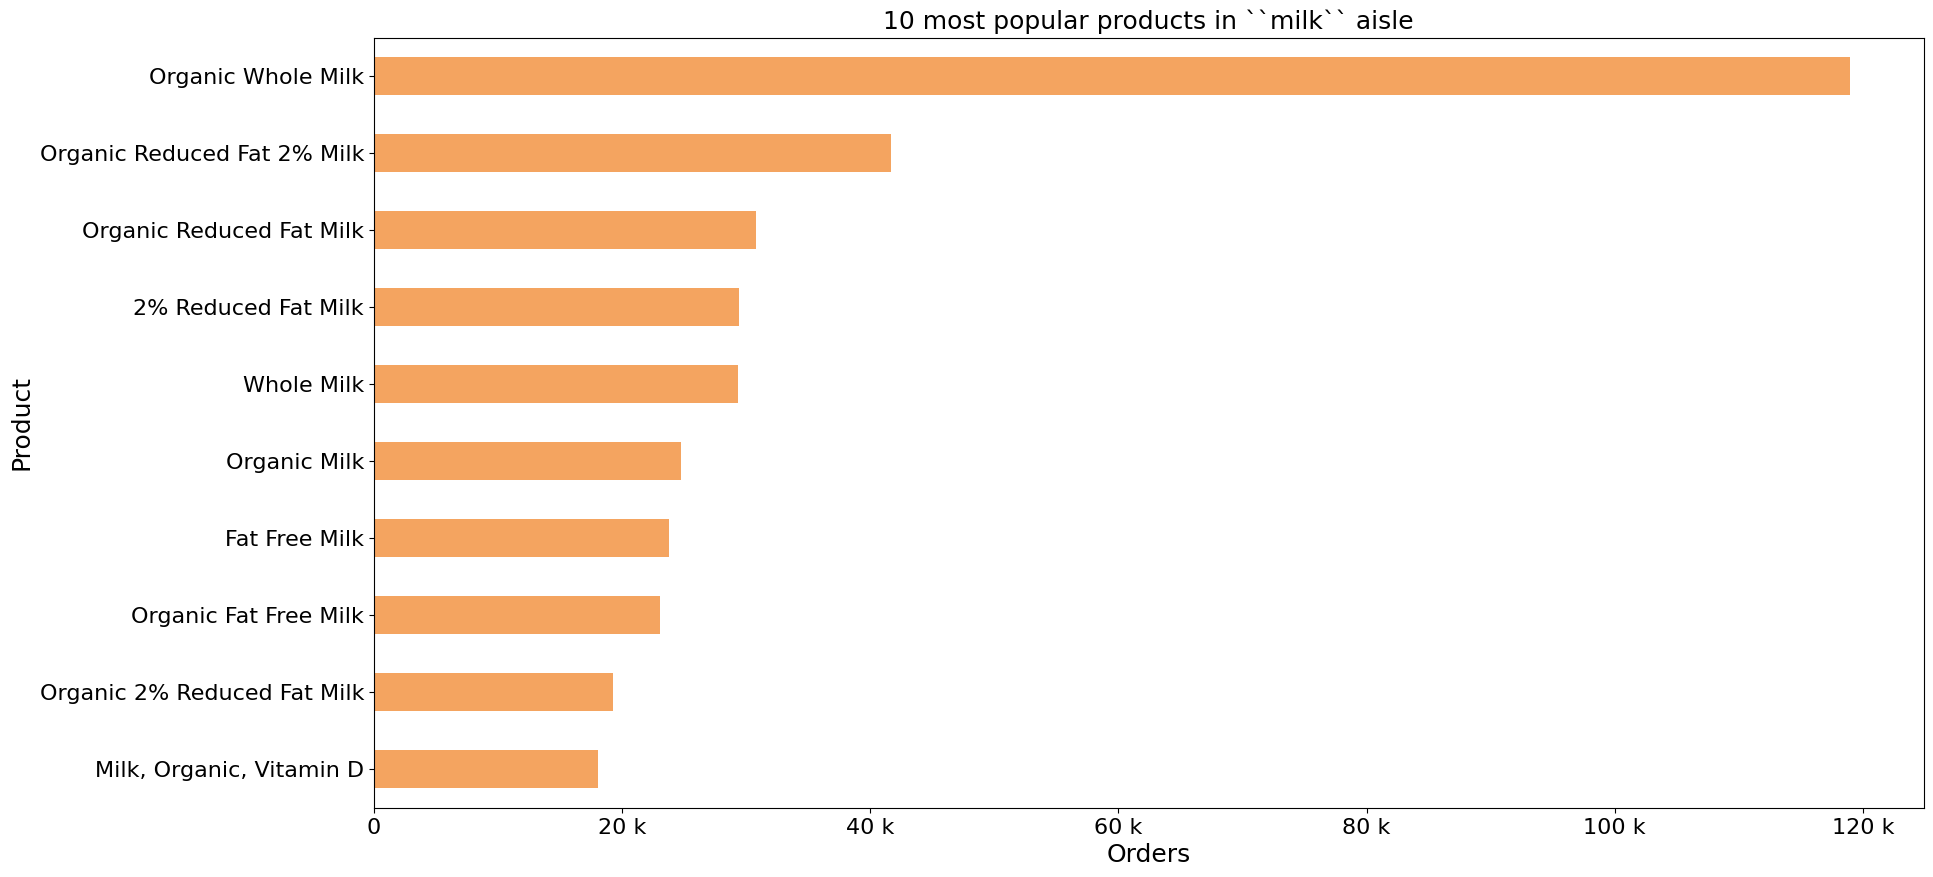

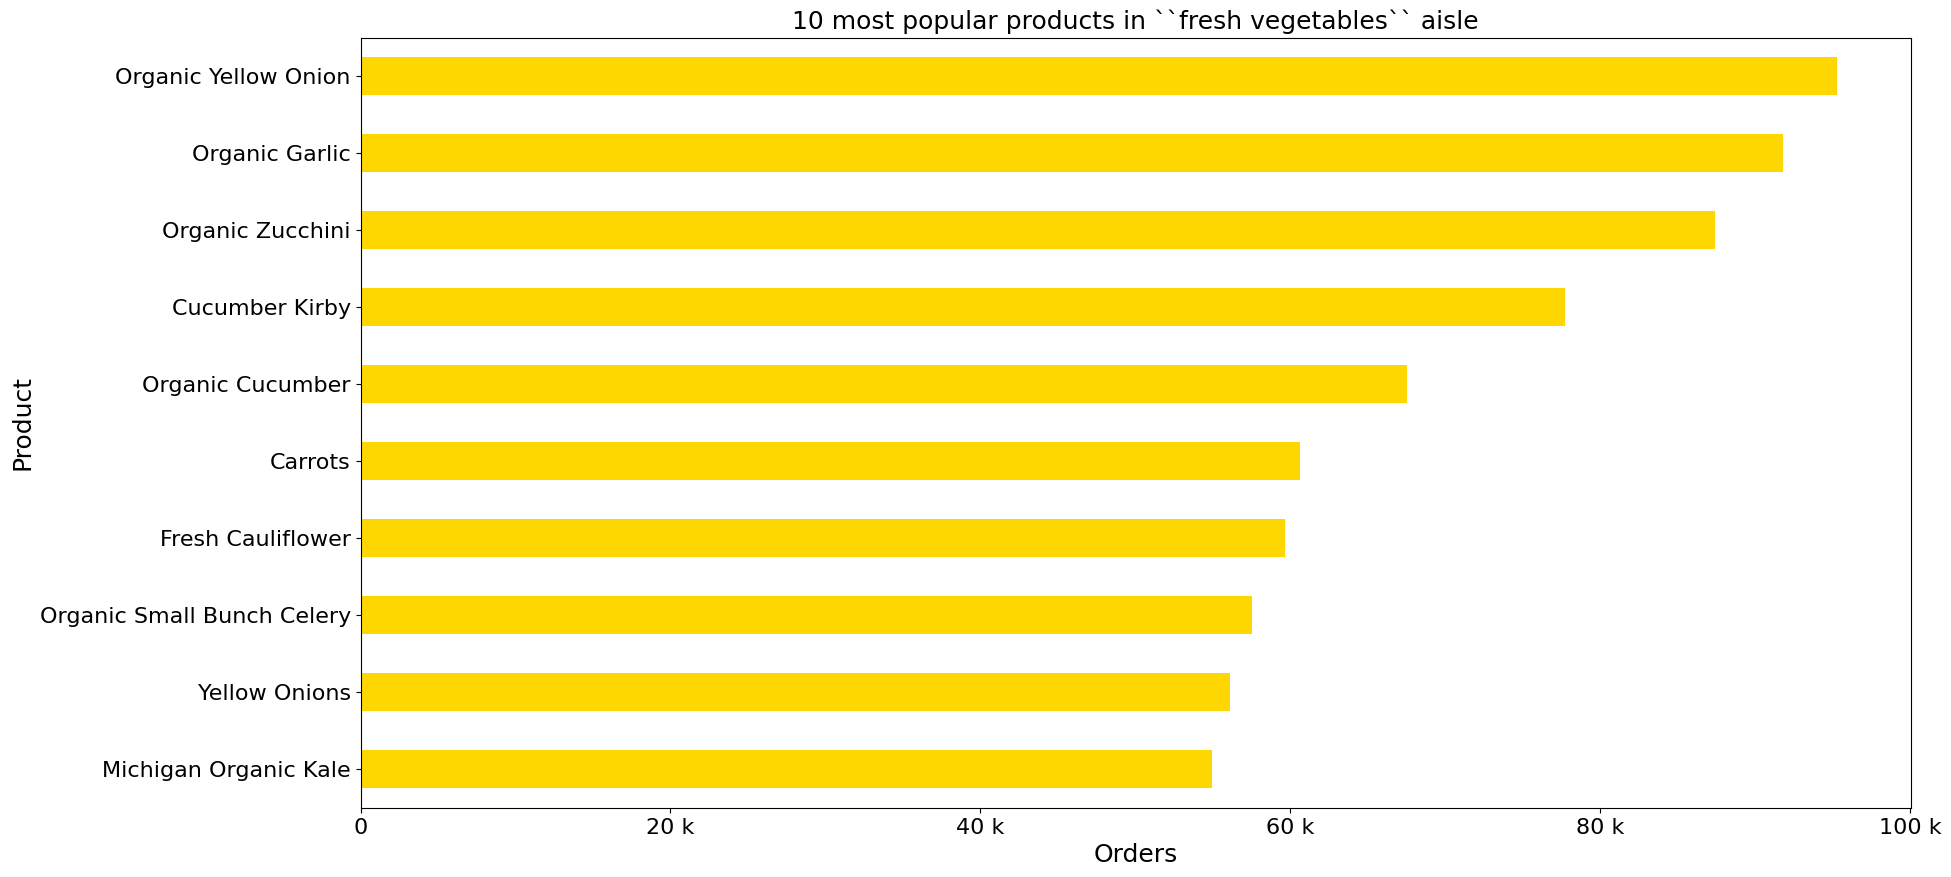

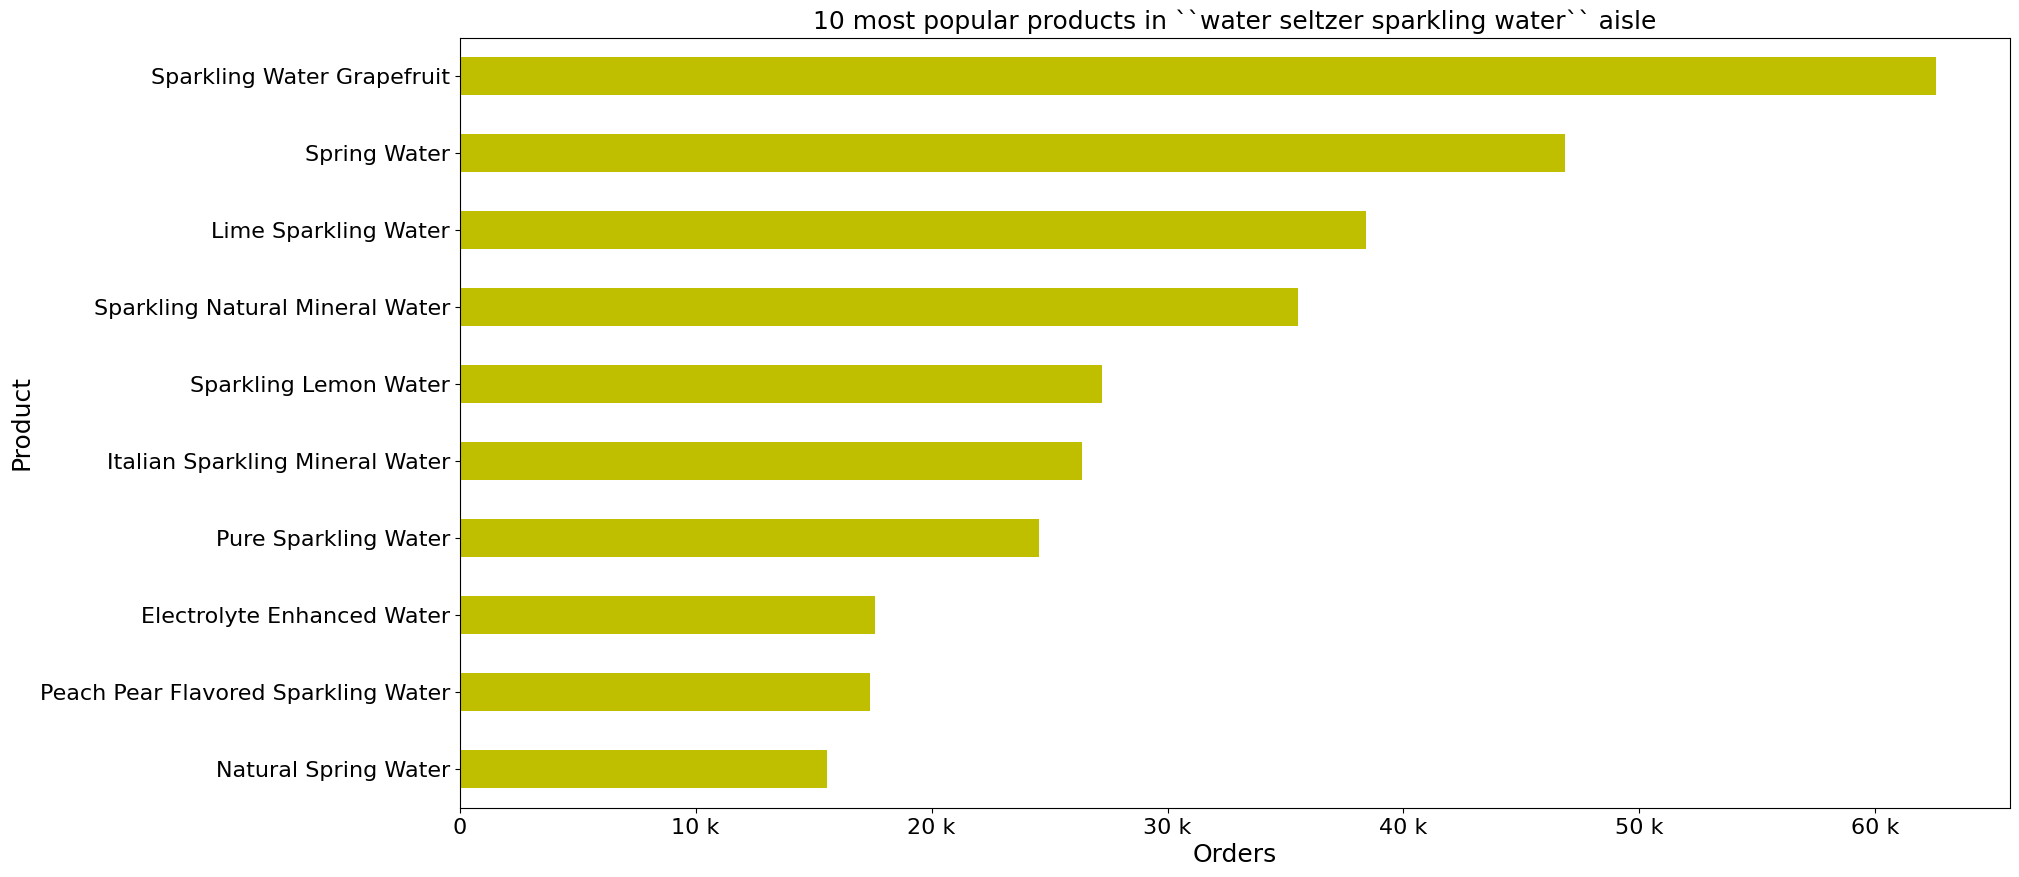

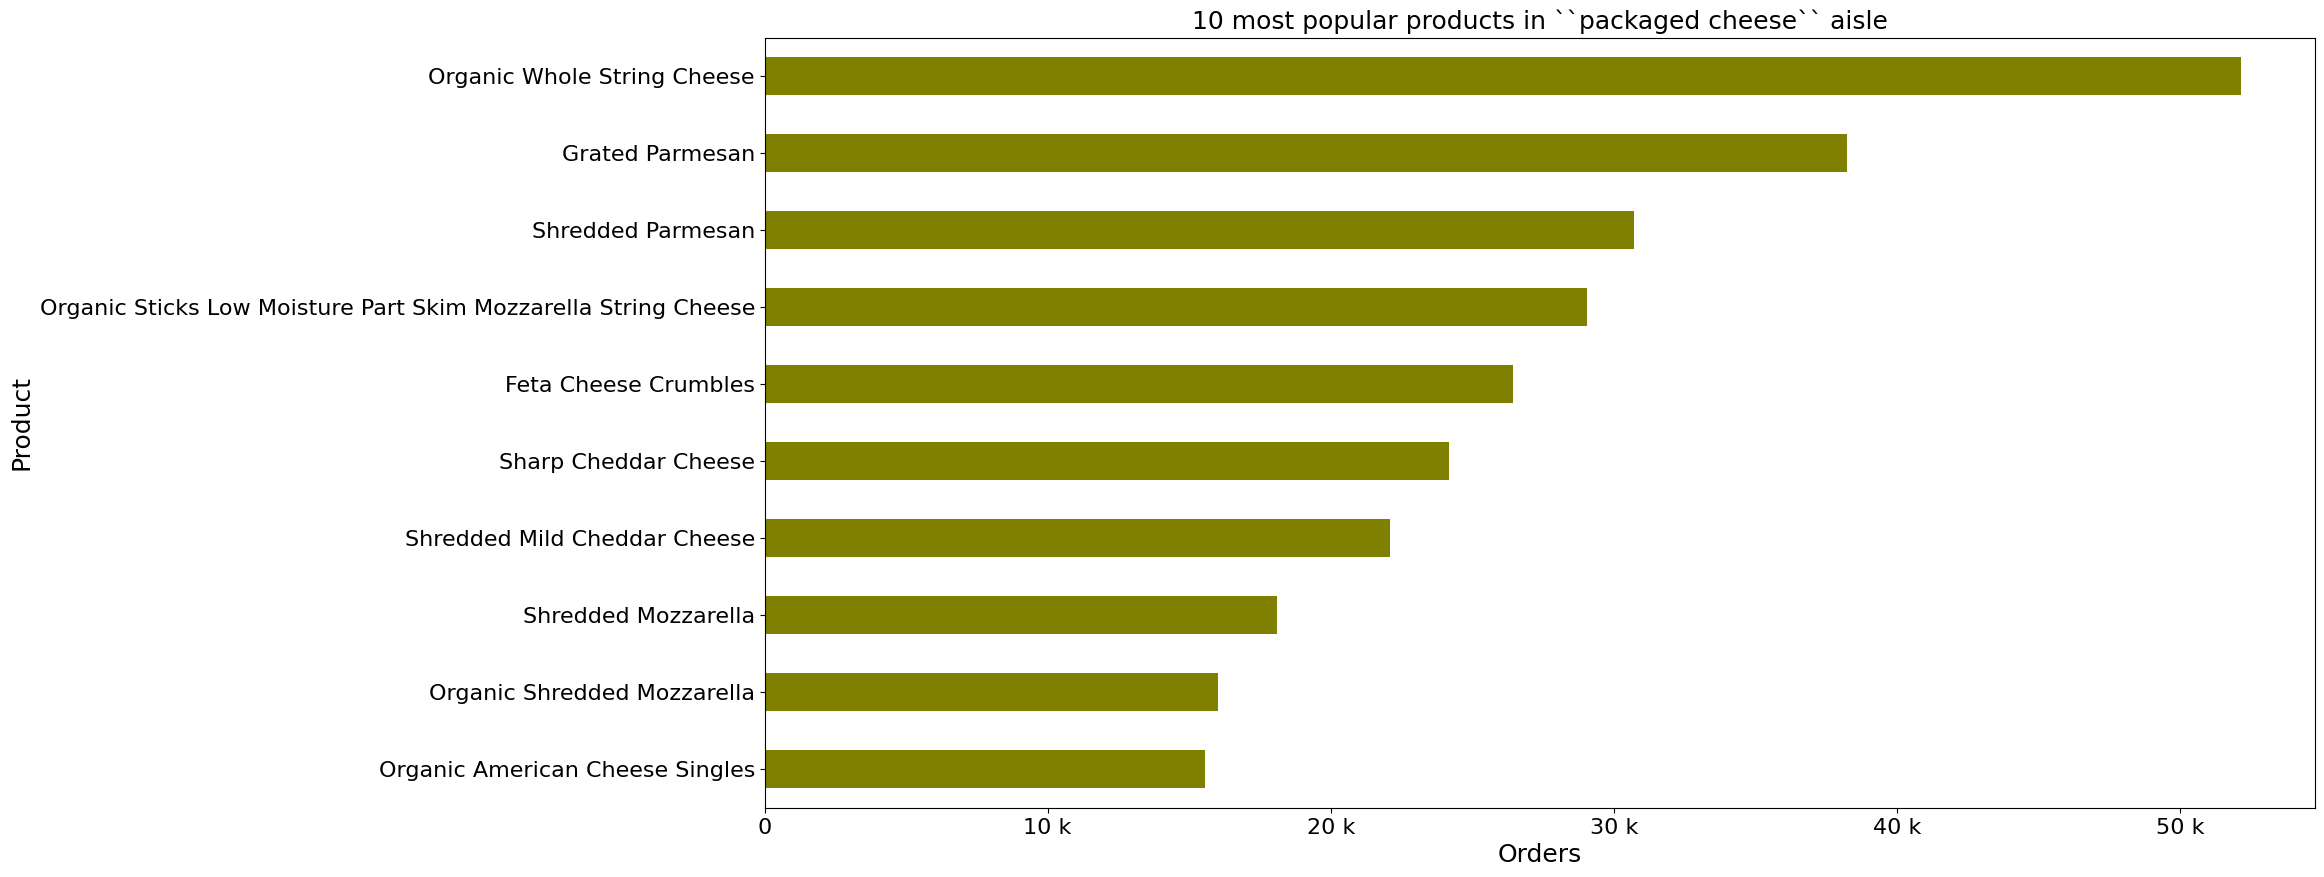

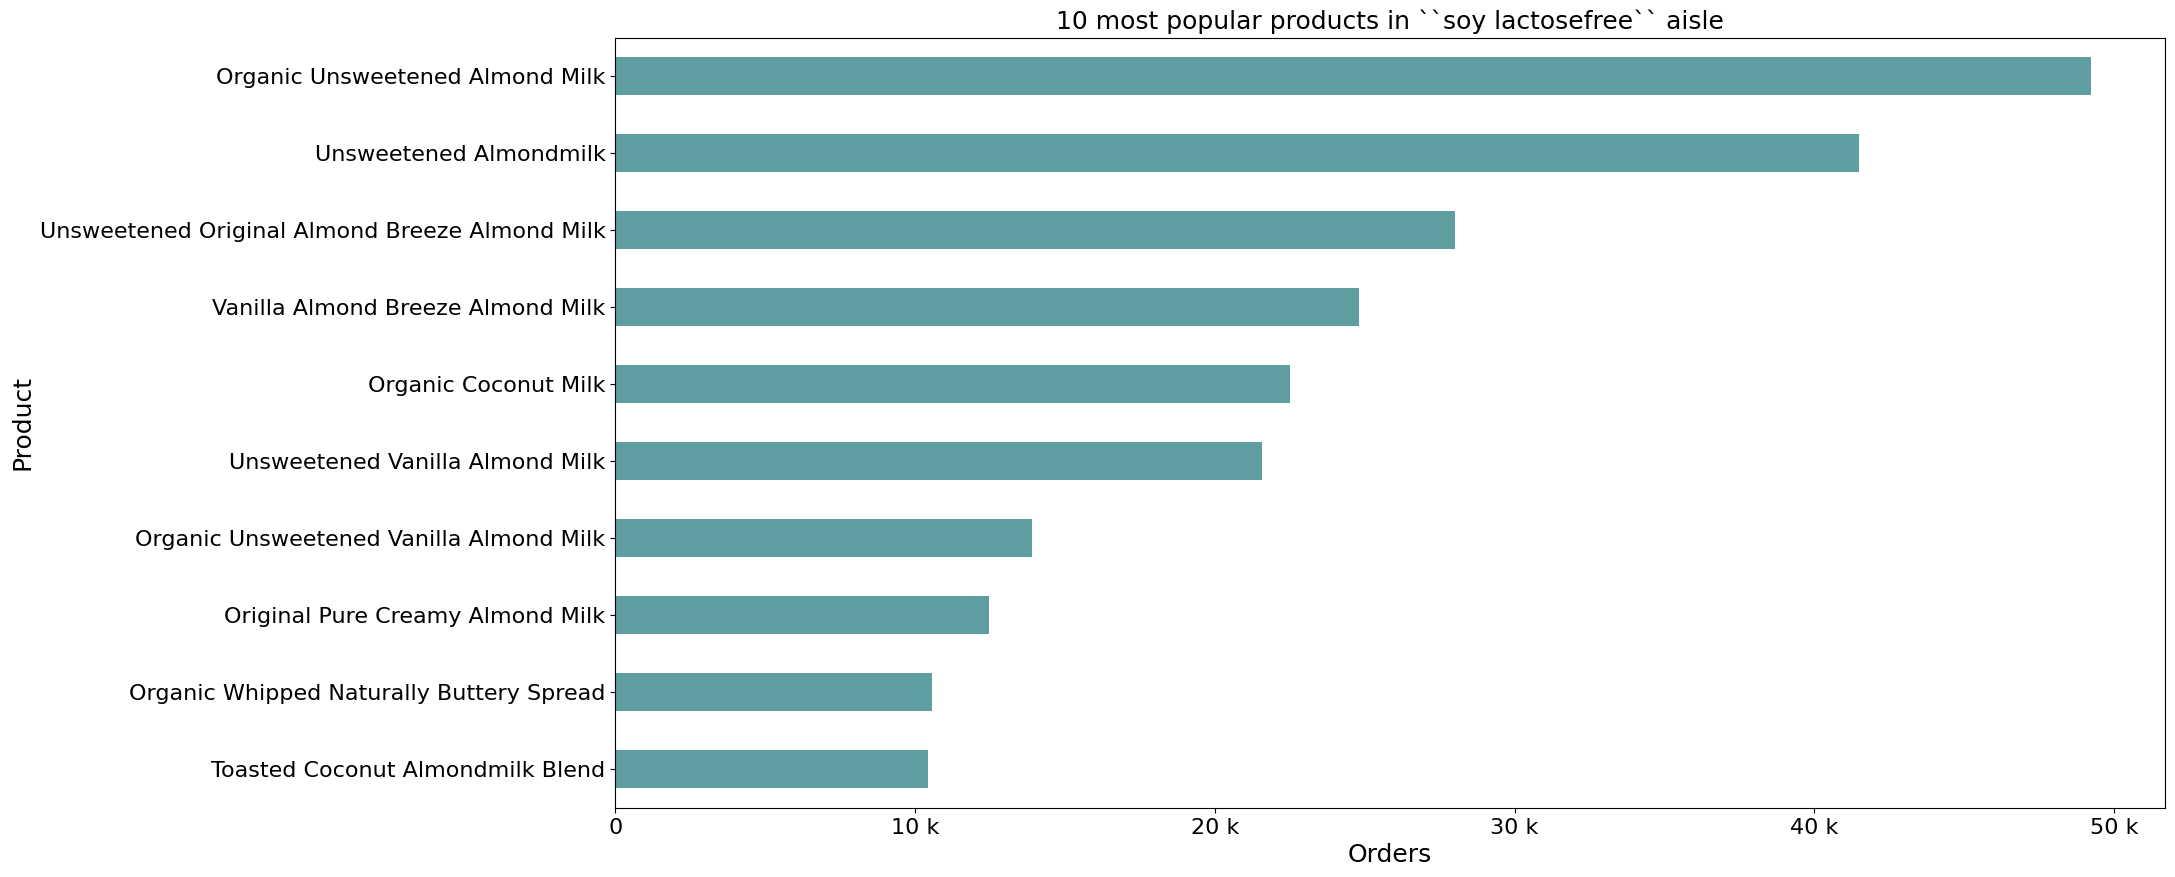

In [40]:
top_10_aisles = main[main.aisle.isin(aisles[:10].aisle.to_list())]
prods_in_aisles = top_10_aisles[['aisle','product_name']].value_counts().to_frame(name="orders").reset_index()
b_colors = ['indianred','salmon','sandybrown','gold','y','olive','teal','cadetblue','steelblue','slateblue']
for aisle,c in zip(list(prods_in_aisles.aisle.unique()),b_colors):
    tmp_df = prods_in_aisles[prods_in_aisles.aisle.eq(aisle)]\
                .dropna()\
                .sort_values(by='orders')[-10:]
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.title("10 most popular products "+ "in " + "``" + aisle + "``" + ' aisle', fontsize=18)
    b = tmp_df.plot.barh(x='product_name', ax=ax, legend=None, fontsize=18, color = c)
    b.tick_params(labelsize=16)
    b.set_xlabel("Orders",fontsize=18)
    b.set_ylabel("Product",fontsize=18)
    b.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.show()

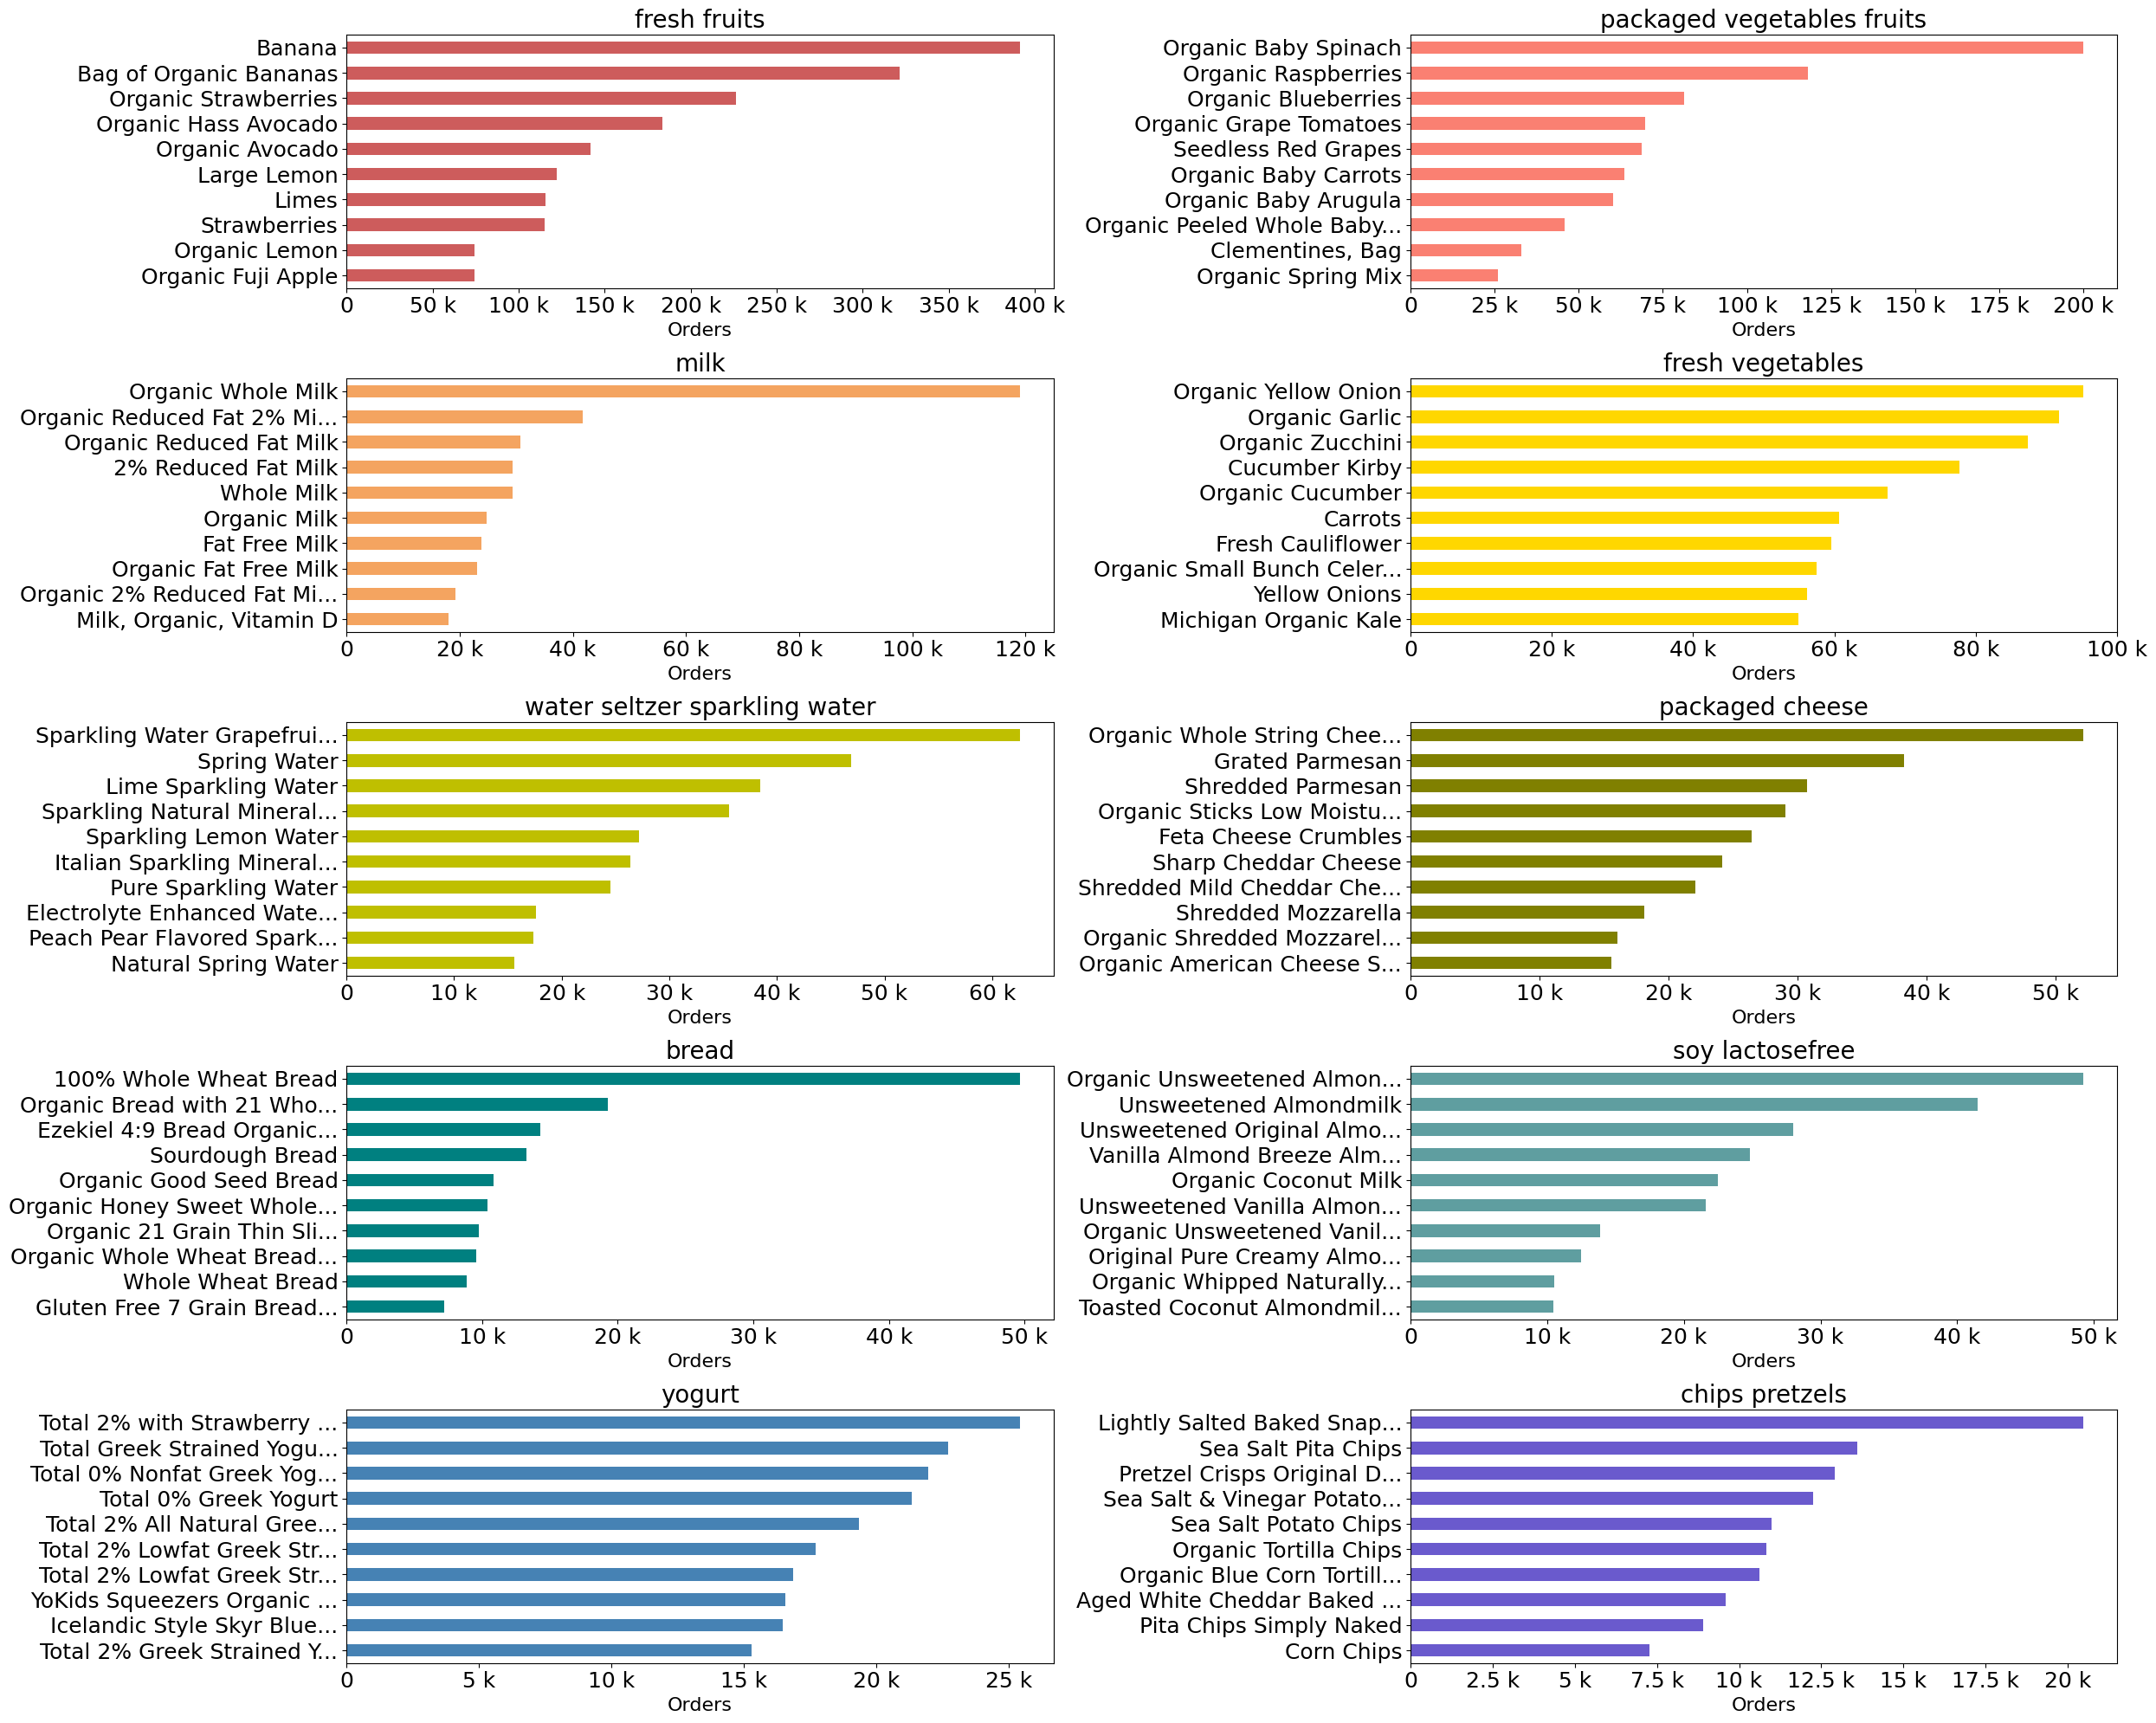

In [41]:
#То же, в виде subplots
fig,axes = plt.subplots(5,2, sharex=False, squeeze=False, figsize=(25,20))
for ax,q, c in zip(axes.ravel(), prods_in_aisles.aisle.unique(), b_colors):
    tmp_df = prods_in_aisles[prods_in_aisles.aisle.eq(q)]\
                .dropna()\
                .sort_values(by='orders')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    b = tmp_df.plot.barh(x='product_name', ax=ax, legend=None, fontsize=18, color = c)
    b.set_xlabel("Orders",fontsize=16)
    b.set_ylabel("Product",fontsize=16)
    b.set_yticklabels((item.get_text()[:25] + '...') if len(item.get_text())>=25 else item.get_text() for item in b.get_yticklabels())
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

*Промежуточный вывод:* Видно, что через сервис покупают больше всего пищевых продуктов (категории produce,dairy eggs, snacks, beverages, frozen и т.д.)

Очень интересно посмотреть, сколько в топ продуктов, которые покупают РЕЖЕ всего, продуктов из категорий "missing" и "other".

In [42]:
#Для удобства ограничимся продукцией, которая покупалась менее или ровно 10 раз:
loosers = list(prods.product_name[prods['orders_by_prod'] <= 10].unique())
len(loosers) #к-во

10689

In [43]:
#Пересечение со списком "missing"
len(set(main.product_name[main['department'] == 'missing'].unique()) & set(loosers))

693

In [44]:
#Пересечение со списком "other"
len(set(main.product_name[main['department'] == 'other'].unique()) & set(loosers))

199

В итоге, мы получаем чуть менее 900 элементов, которые могут быть плохо покупаемыми в связи с ошибочно проставленной категорией продукции.

In [45]:
#А если взять все единички?
main_loosers = list(prods.product_name[prods['orders_by_prod'] <= 1].unique())
len(main_loosers) #к-во

590

In [46]:
#Снова пересечение со списком "missing"
len(set(main.product_name[main['department'] == 'missing'].unique()) & set(main_loosers))

64

In [47]:
#И со списком "other"
len(set(main.product_name[main['department'] == 'other'].unique()) & set(main_loosers))

10

74 элемента из 590 это уже достаточно весомая сумма.Вывод напрашивается тот же - необходимость корректировки данных по категориям со стороны магазина.

In [48]:
# И, наконец, можно посмотреть на временную составляющю данных. Начнем с дня недели транзакции.
dow = main['order_dow'].value_counts().to_frame(name="orders_by_dow")
dow = dow.reset_index()
#Поделим на тысячу для удобства отображения на графике:
dow['orders_by_prod_ths'] = dow.orders_by_dow/1e3
#Заменим числовые значения на названия дня недели:
dow_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
dow['dow_tr'] = [dow_dict.get(k) for k in dow['order_dow']]

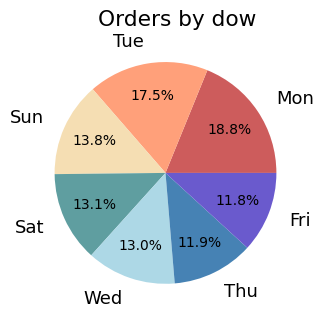

In [49]:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(dow.orders_by_prod_ths, autopct='%1.1f%%', labeldistance=1.2, radius=1.2, \
                                  colors = ['indianred','lightsalmon','wheat','cadetblue','lightblue','steelblue','slateblue'],\
                                  pctdistance=0.7, labels = dow.dow_tr)
    ax.set_title('Orders by dow', x=0.55, y=1.1)
    ax.tick_params(labelsize=14, color = "white")
#     ax.legend(wedges,
#               dow.dow_tr,
#               title="Orders, k",
#               bbox_to_anchor=(1.2, 0.22, 0.5, 0.75))
plt.show()

*Промежуточный вывод:* Чуть большая часть покупок производится в понедельник и вторник, чуть меньшая - в четверг и пятницу. Какой-то явной закономерности нет.

In [50]:
# Оценим данные в разрезе времени транзакции:
ord_time = main['order_hour_of_day'].value_counts().to_frame(name="orders_by_h")
ord_time = ord_time.reset_index()
#Поделим на тысячу для удобства отображения на графике:
ord_time['orders_by_prod_ths'] = ord_time.orders_by_h/1e3
#Сортировка по порядку времени:
ord_time= ord_time.sort_values(by = 'order_hour_of_day')

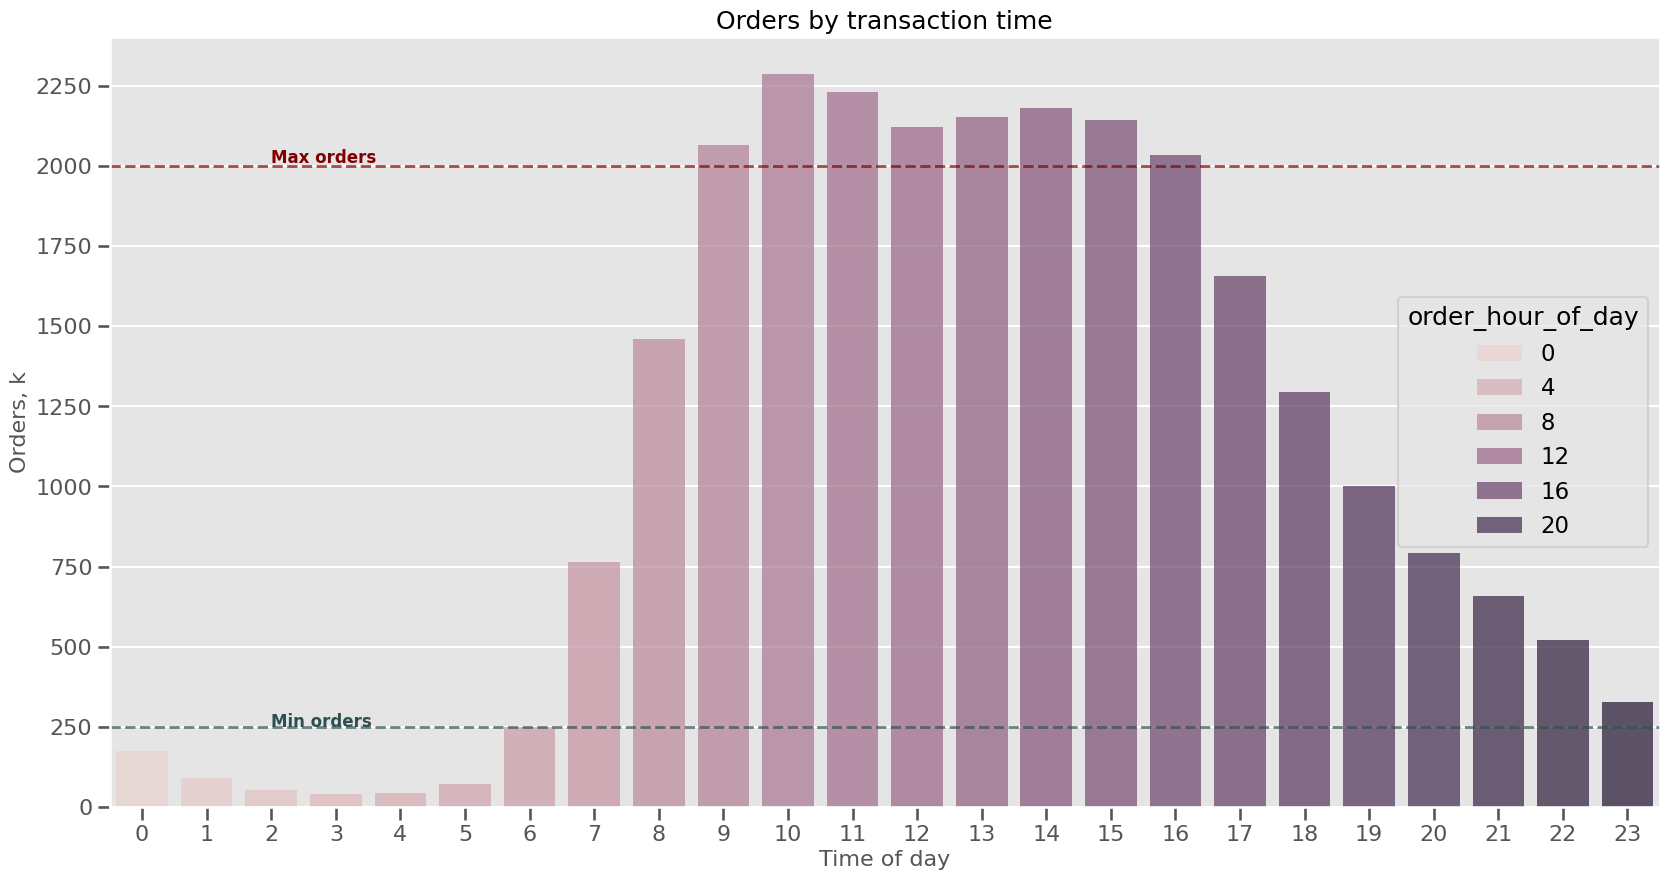

In [51]:
#Построим barplot:
with plt.style.context(['ggplot']):
    plt.figure(figsize=(20,10))
    sns.set_context("talk", rc={"lines.linewidth": 1.5, "font.size":16,"axes.titlesize":18,"axes.labelsize":16})
    b = sns.barplot(ord_time, y=ord_time.orders_by_prod_ths, x=ord_time.order_hour_of_day, alpha=0.75, \
                    hue = ord_time.order_hour_of_day)
    b.axes.set_title("Orders by transaction time", fontsize=18)
    b.set_xlabel("Time of day",fontsize=16)
    b.set_ylabel("Orders, k",fontsize=16)
    b.axhline(y=2000, ls='--', c='maroon', linewidth=2, alpha=.7)
    plt.text(x=2, y=2010, s="Max orders", fontsize = 12, color = 'maroon', weight = 'bold')
    b.axhline(y=250, ls='--', c='darkslategray', linewidth=2, alpha=.7)
    plt.text(x=2, y=250, s="Min orders", fontsize = 12, color = 'darkslategray', weight = 'bold')
    ticks = np.arange(0, 2500, 250)
    b.set_yticks(ticks)
    b.set_yticklabels(ticks)
    b.tick_params(labelsize=16)
plt.show()

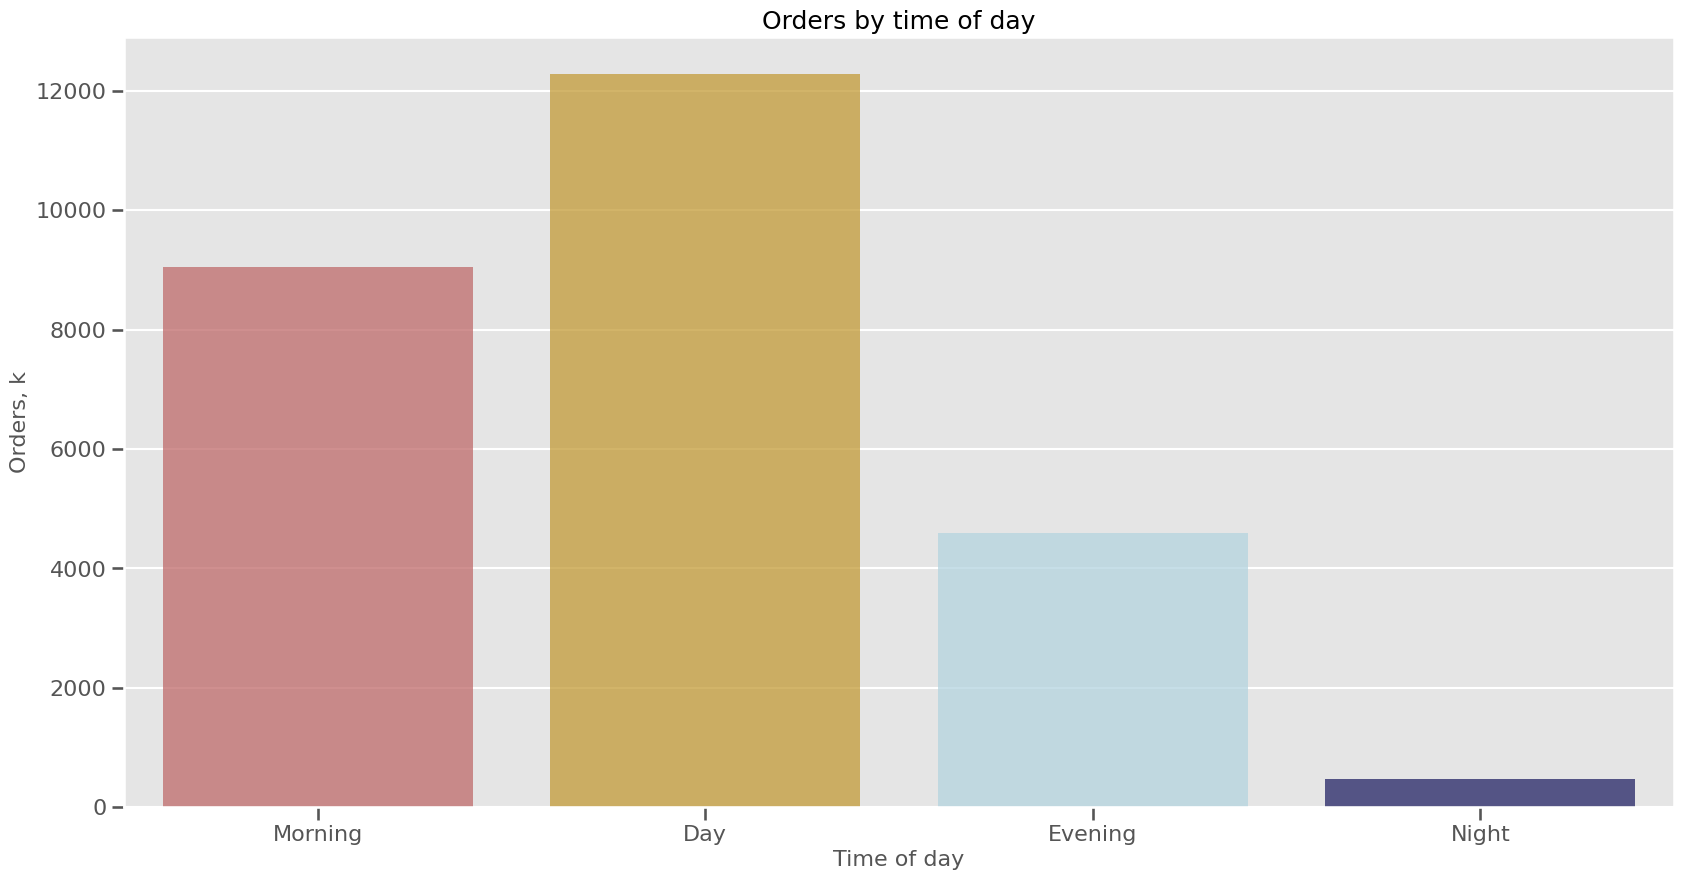

In [52]:
#Разобъем на группы для визуализации:
def group_tod(x):
    if 0 <= x < 6:
        y = 'Night'
    elif 6 <= x < 12:
        y = 'Morning'
    elif 12 <= x < 18:
        y = 'Day'
    else:
        y = 'Evening'
    return y

ord_time['tod'] = ord_time['order_hour_of_day'].apply(group_tod)
ord_tod = ord_time[["orders_by_prod_ths","tod"]].groupby(['tod'], as_index=False)['orders_by_prod_ths'].sum()
colors = {'Morning':'indianred','Day':'goldenrod','Evening':'lightblue','Night':'midnightblue'}
#Построим barplot:
with plt.style.context(['ggplot']):
    plt.figure(figsize=(20,10))
    sns.set_context("talk", rc={"lines.linewidth": 1.5, "font.size":16,"axes.titlesize":18,"axes.labelsize":16})
    b = sns.barplot(ord_tod, y=ord_tod.orders_by_prod_ths, x=ord_tod.tod, alpha=0.75, \
            order = ['Morning','Day','Evening','Night'], hue = ord_tod.tod, palette = [colors[key] for key in ord_tod.tod])
    b.axes.set_title("Orders by time of day", fontsize=18)
    b.set_xlabel("Time of day",fontsize=16)
    b.set_ylabel("Orders, k",fontsize=16)
#     ticks = np.arange(0, 10, 1)
#     b.set_yticks(ticks)
#     b.set_yticklabels(ticks)
    b.tick_params(labelsize=16)
plt.show()

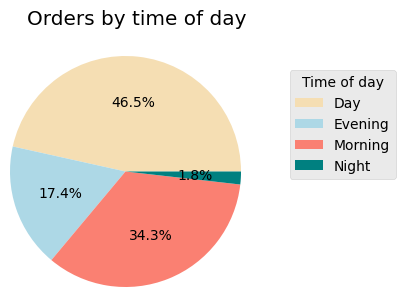

In [53]:
#В виде pichart:
colors = {'Morning':'salmon','Day':'wheat','Evening':'lightblue','Night':'teal'}
with plt.style.context(['ggplot']):

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(ord_tod.orders_by_prod_ths, autopct='%1.1f%%', labeldistance=1.1, radius=1.25, \
                                  colors = [colors[key] for key in ord_tod.tod])
    ax.set_title('Orders by time of day', x=0.55, y=1.1)
    ax.tick_params(labelsize=14, color = "white")
    ax.legend(wedges,
              ord_tod.tod,
              title="Time of day",
              bbox_to_anchor=(1.2, 0.22, 0.5, 0.75))
plt.show()

*Промежуточный вывод:* Что логично, большая часть покупок приходится на утреннее и дневное время. Меньше всего покупок ночью. Больше всего заказов приходится на период с 9 до 16 часов, меньше всего - с полнуочи до 6 часов утра.

Заодно посмотрим на количество заказов для каждого отрезка времени дня по дням недели, чтобы убедиться в отсутсвии каких-либо неочевидных закономерностей.

In [54]:
#Группировка по дням недели и часам:
dow_time = main.groupby(['order_dow','order_hour_of_day'])['order_id']\
    .count()\
    .reset_index()
dow_time['orders_ths'] = dow_time.order_id/1e3
#Группировка времени в отрезки утро-день-вечер-ночь для удобства:
dow_time['tod'] = dow_time['order_hour_of_day'].apply(group_tod)
dow_time = dow_time[["orders_ths","tod","order_dow"]].groupby(["order_dow","tod"], as_index=False)['orders_ths'].sum()
#Подтянем названия дней недели из словаря:
dow_time['dow_tr'] = [dow_dict.get(k) for k in dow_time['order_dow']]

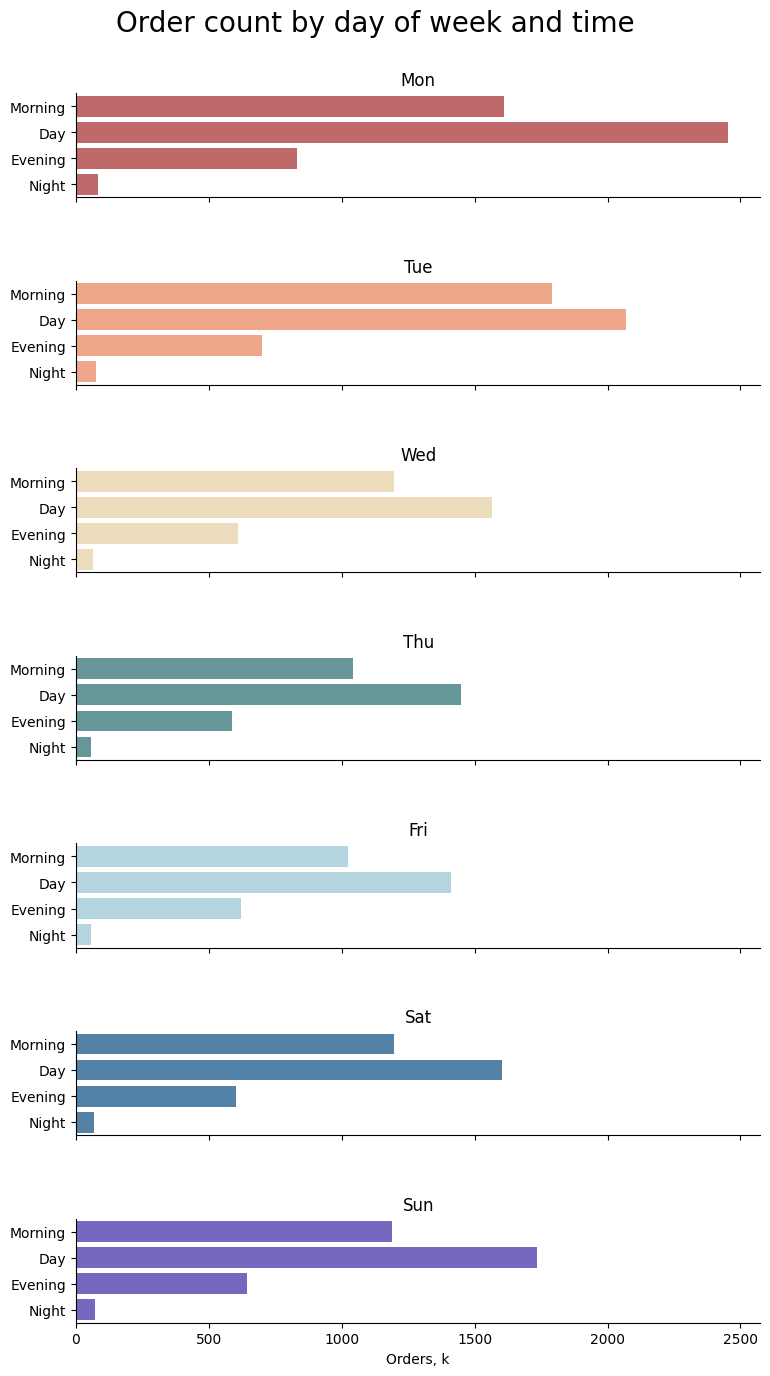

In [55]:
#Визуализируем результат:
dow_time = main.groupby(['order_dow','order_hour_of_day'])['order_id']\
    .count()\
    .reset_index()
dow_time['orders_ths'] = dow_time.order_id/1e3
dow_time['tod'] = dow_time['order_hour_of_day'].apply(group_tod)
dow_time = dow_time[["orders_ths","tod","order_dow"]].groupby(["order_dow","tod"], as_index=False)['orders_ths'].sum()
dow_time['dow_tr'] = [dow_dict.get(k) for k in dow_time['order_dow']]

g = sns.catplot(data=dow_time, x='orders_ths', y='tod', row='dow_tr', order=['Morning','Day','Evening','Night'], 
            hue = dow_time.dow_tr, palette = ['indianred','lightsalmon','wheat','cadetblue','lightblue','steelblue','slateblue'],
            kind='bar', height=2, aspect=4,  sharex=True, sharey=False, legend = None)
g.set_axis_labels("Orders, k", "")
g.fig.subplots_adjust(top=0.92, hspace = 0.8)
g.fig.suptitle('Order count by day of week and time', fontsize=20)
ordered_titlelist = ['Mon','Tue','Wed','Thu', 'Fri','Sat','Sun']
for idx,ax in enumerate(g.axes.flat):
    ax.set_title(ordered_titlelist[idx])
    ax.tick_params(axis='x')

*Промежуточный вывод:* Каких-то аномалий здесь замечено не было, тренд одинаков для всех дней недели - больше покупок днем, меньше ночью, пропорции примерно одинаковые и подтверждают ранее выявленные закономерности.

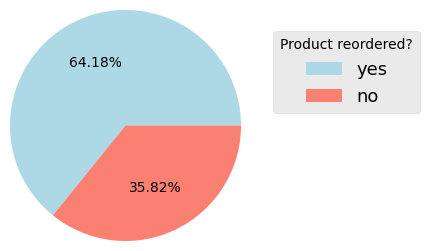

In [56]:
# Расмотрим столбец "reordered", посмотрим сколько продуктов в итоге перезаказали, а сколько нет в процентном соотношении:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    data = [len(main[main['reordered'] == 1]), len(main[main["reordered"] == 0])]
    lbs = ['yes','no']
    wedges, texts, autotexts = ax.pie(data, autopct='%1.2f%%', labeldistance=1.1, radius=1.25, \
                                  colors = ['lightblue', 'salmon'])
    ax.legend(wedges,
              lbs,
              title="Product reordered?",
              bbox_to_anchor=(1.1, 0.2, 0.5, 0.75))
plt.show()

*Промежуточный вывод:* Значительную часть продукции заказывали неоднократно (чуть менее 65%), что, естественно, неплохо.

Построим своеобразную метрику популярности продукта, просуммировав к-во перезаказов по продуктам. Эта метрика более надежна в качестве показателя популярности продукта, чем простое количество покупок по товару, т.к. еще учитывает и частоту покупки.

In [57]:
popularity = main.groupby(['product_id','product_name'])['reordered'].sum().reset_index()
popularity.describe()

product_id      reordered
count  49465.000000   49465.000000
mean   24837.428505     342.646477
std    14341.082810    3198.484463
min        1.000000       0.000000
25%    12418.000000       3.000000
50%    24832.000000      19.000000
75%    37254.000000     101.000000
max    49688.000000  347066.000000

In [58]:
popularity.sort_values(by = 'reordered', ascending = False).head(20)

product_id              product_name  reordered
24752       24852                    Banana   347066.0
13119       13176    Bag of Organic Bananas   280724.0
21052       21137      Organic Strawberries   186420.0
21814       21903      Organic Baby Spinach   164673.0
47001       47209      Organic Hass Avocado   154014.0
47555       47766           Organic Avocado   114847.0
27728       27845        Organic Whole Milk   103208.0
27849       27966       Organic Raspberries    95712.0
47417       47626               Large Lemon    92018.0
16729       16797              Strawberries    86999.0
26099       26209                     Limes    85300.0
22842       22935      Organic Yellow Onion    71377.0
24863       24964            Organic Garlic    67422.0
44813       45007          Organic Zucchini    64505.0
49459       49683            Cucumber Kirby    58250.0
8239         8277  Apple Honeycrisp Organic    57102.0
28087       28204        Organic Fuji Apple    56716.0
39109       39275       Organic Blueberries    55332.0
5847         5876             Organic Lemon    54850.0
49016       49235       Organic Half & Half    53978.0

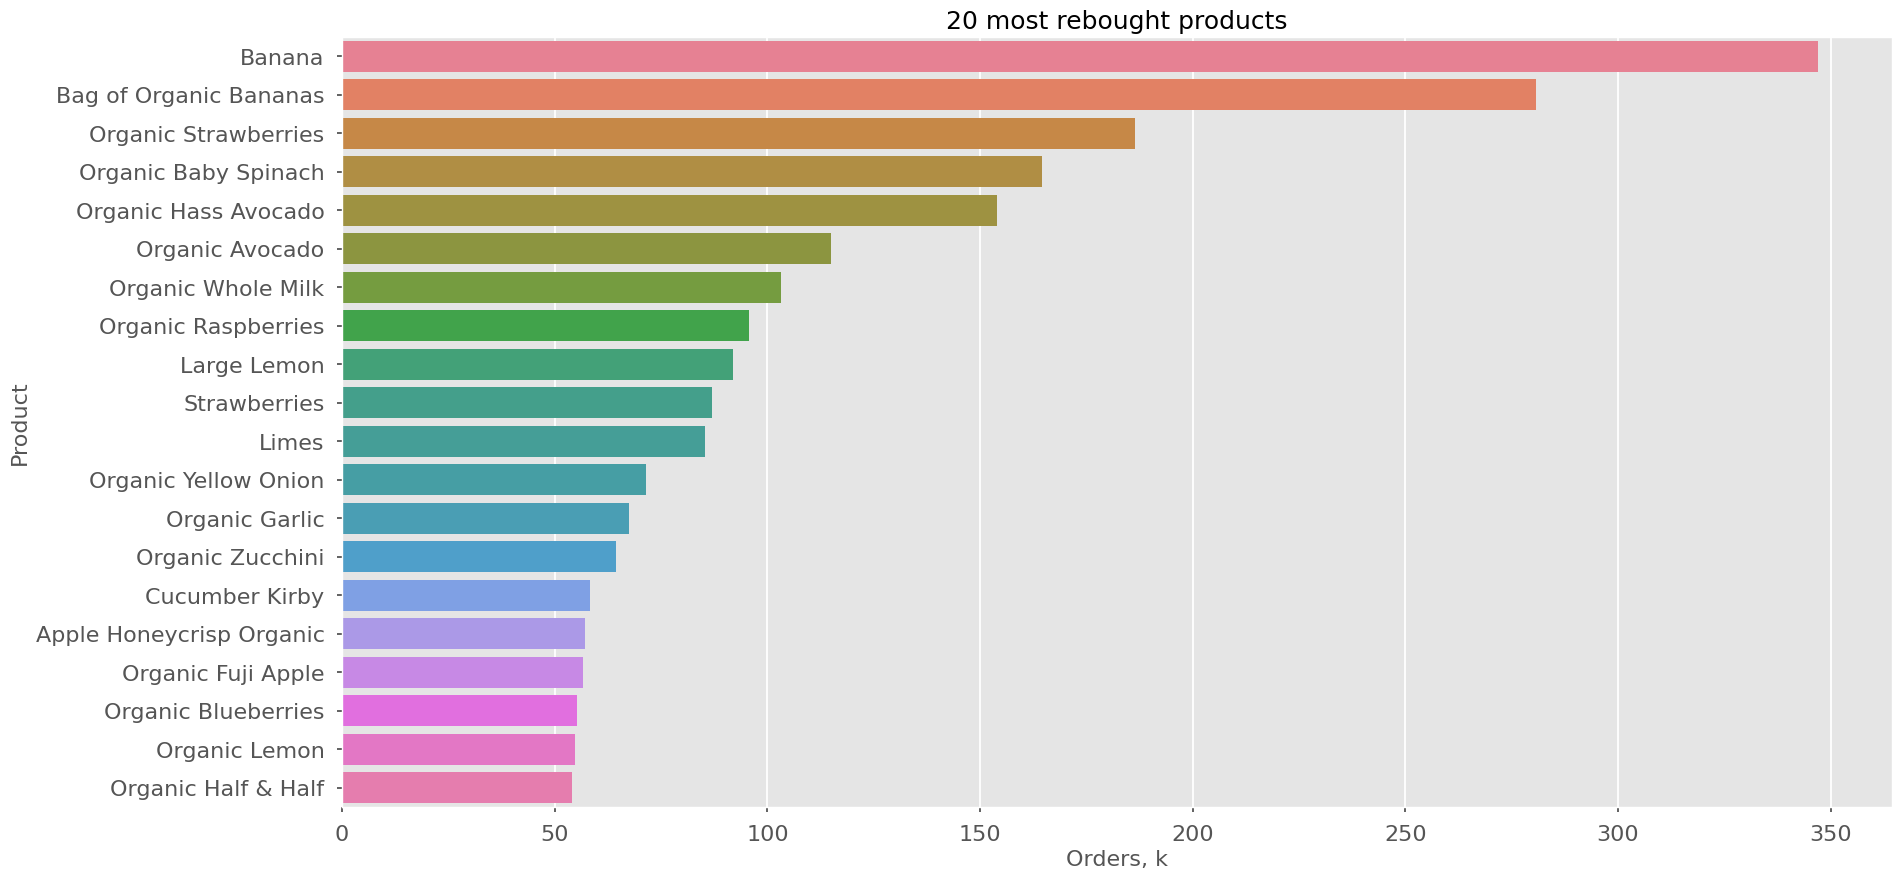

In [59]:
#И барплот:
most_popular = popularity.sort_values(by = 'reordered', ascending = False).head(20)
most_popular['reordered_k'] = most_popular['reordered']/1e3
#Построим диаграмму:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    plt.figure(figsize=(20,10))
    plt.title("20 most rebought products", fontsize=18)
    plt.tick_params(labelsize=16)
    b = sns.barplot(y=most_popular.product_name, x=most_popular.reordered_k, hue = most_popular.product_name)
    b.set_xlabel("Orders, k",fontsize=16)
    b.set_ylabel("Product",fontsize=16)
plt.show()

In [60]:
#Посмотрим на обе метрики популярности на одном графике.
#Удалим и переименуем лишнее, установим label столбец:
most_popular.drop(columns = ['product_id'], inplace = True)
prods_max['cat'] = 'most_bought'
most_popular['cat'] = 'most_reordered'
prods_max.rename(columns={'orders_by_prod':'orders','orders_by_prod_ths':'orders_k'}, inplace=True)
most_popular.rename(columns={'reordered':'orders','reordered_k':'orders_k'}, inplace=True)
#Собственно объединение:
popular_df = pd.concat([most_popular,prods_max])
popular_df.groupby(['product_name','cat'], as_index=False)['orders_k'].max()

/tmp/ipykernel_218143/2635195675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prods_max['cat'] = 'most_bought'
/tmp/ipykernel_218143/2635195675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prods_max.rename(columns={'orders_by_prod':'orders','orders_by_prod_ths':'orders_k'}, inplace=True)


product_name             cat  orders_k
0   Apple Honeycrisp Organic     most_bought    73.214
1   Apple Honeycrisp Organic  most_reordered    57.102
2     Bag of Organic Bananas     most_bought   321.553
3     Bag of Organic Bananas  most_reordered   280.724
4                     Banana     most_bought   391.170
5                     Banana  most_reordered   347.066
6             Cucumber Kirby     most_bought    77.719
7             Cucumber Kirby  most_reordered    58.250
8                Large Lemon     most_bought   122.080
9                Large Lemon  most_reordered    92.018
10                     Limes     most_bought   115.506
11                     Limes  most_reordered    85.300
12           Organic Avocado     most_bought   141.632
13           Organic Avocado  most_reordered   114.847
14      Organic Baby Spinach     most_bought   199.961
15      Organic Baby Spinach  most_reordered   164.673
16       Organic Blueberries     most_bought    81.297
17       Organic Blueberries  most_reordered    55.332
18        Organic Fuji Apple     most_bought    74.184
19        Organic Fuji Apple  most_reordered    56.716
20            Organic Garlic     most_bought    91.792
21            Organic Garlic  most_reordered    67.422
22    Organic Grape Tomatoes     most_bought    69.782
23       Organic Half & Half  most_reordered    53.978
24      Organic Hass Avocado     most_bought   183.702
25      Organic Hass Avocado  most_reordered   154.014
26             Organic Lemon     most_bought    74.217
27             Organic Lemon  most_reordered    54.850
28       Organic Raspberries     most_bought   118.073
29       Organic Raspberries  most_reordered    95.712
30      Organic Strawberries     most_bought   226.279
31      Organic Strawberries  most_reordered   186.420
32        Organic Whole Milk     most_bought   118.954
33        Organic Whole Milk  most_reordered   103.208
34      Organic Yellow Onion     most_bought    95.262
35      Organic Yellow Onion  most_reordered    71.377
36          Organic Zucchini     most_bought    87.410
37          Organic Zucchini  most_reordered    64.505
38              Strawberries     most_bought   115.320
39              Strawberries  most_reordered    86.999

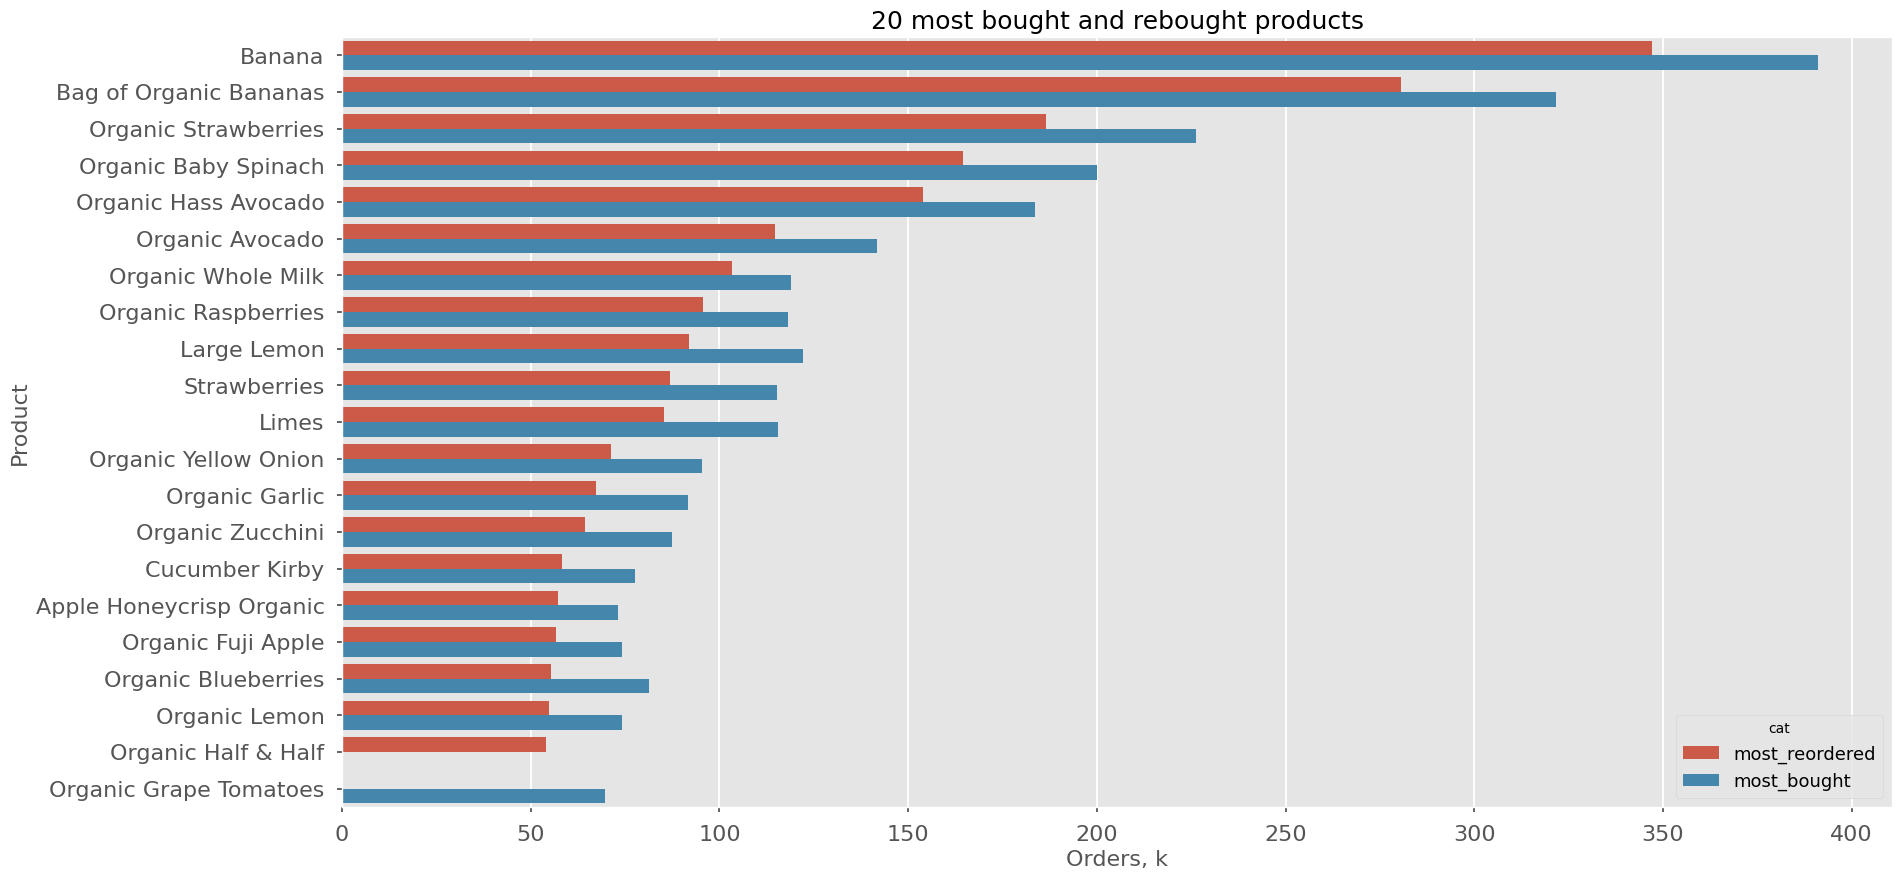

In [61]:
#Две диаграммы на одном графике:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):
    plt.figure(figsize=(20,10))
    plt.title("20 most bought and rebought products", fontsize=18)
    plt.tick_params(labelsize=16)
    b = sns.barplot(y=popular_df.product_name, x=popular_df.orders_k, hue = popular_df.cat)
    b.set_xlabel("Orders, k",fontsize=16)
    b.set_ylabel("Product",fontsize=16)
plt.show()

*Промежуточный вывод:* В принципе, в основном топ наиболее покупаемых продуктов и продуктов, которые больше всего раз были перезаказаны, совпадает вплоть до 20-й позиции, где обнаруживается первое расхождение. Поэтому для построения popularity based рекомендательной системы можно использовать любую из этих двух характеристик.

In [62]:
#Немного заморочимся и изучим состав продуктовой корзины по дням недели.
#Снова группируем данные
prod_dow = main.groupby(['order_dow','product_name'])['order_id']\
    .count()\
    .reset_index()
#Переименуем столбцы для удобства работы с ними:
prod_dow.columns = ['dow','product','orders_cnt']

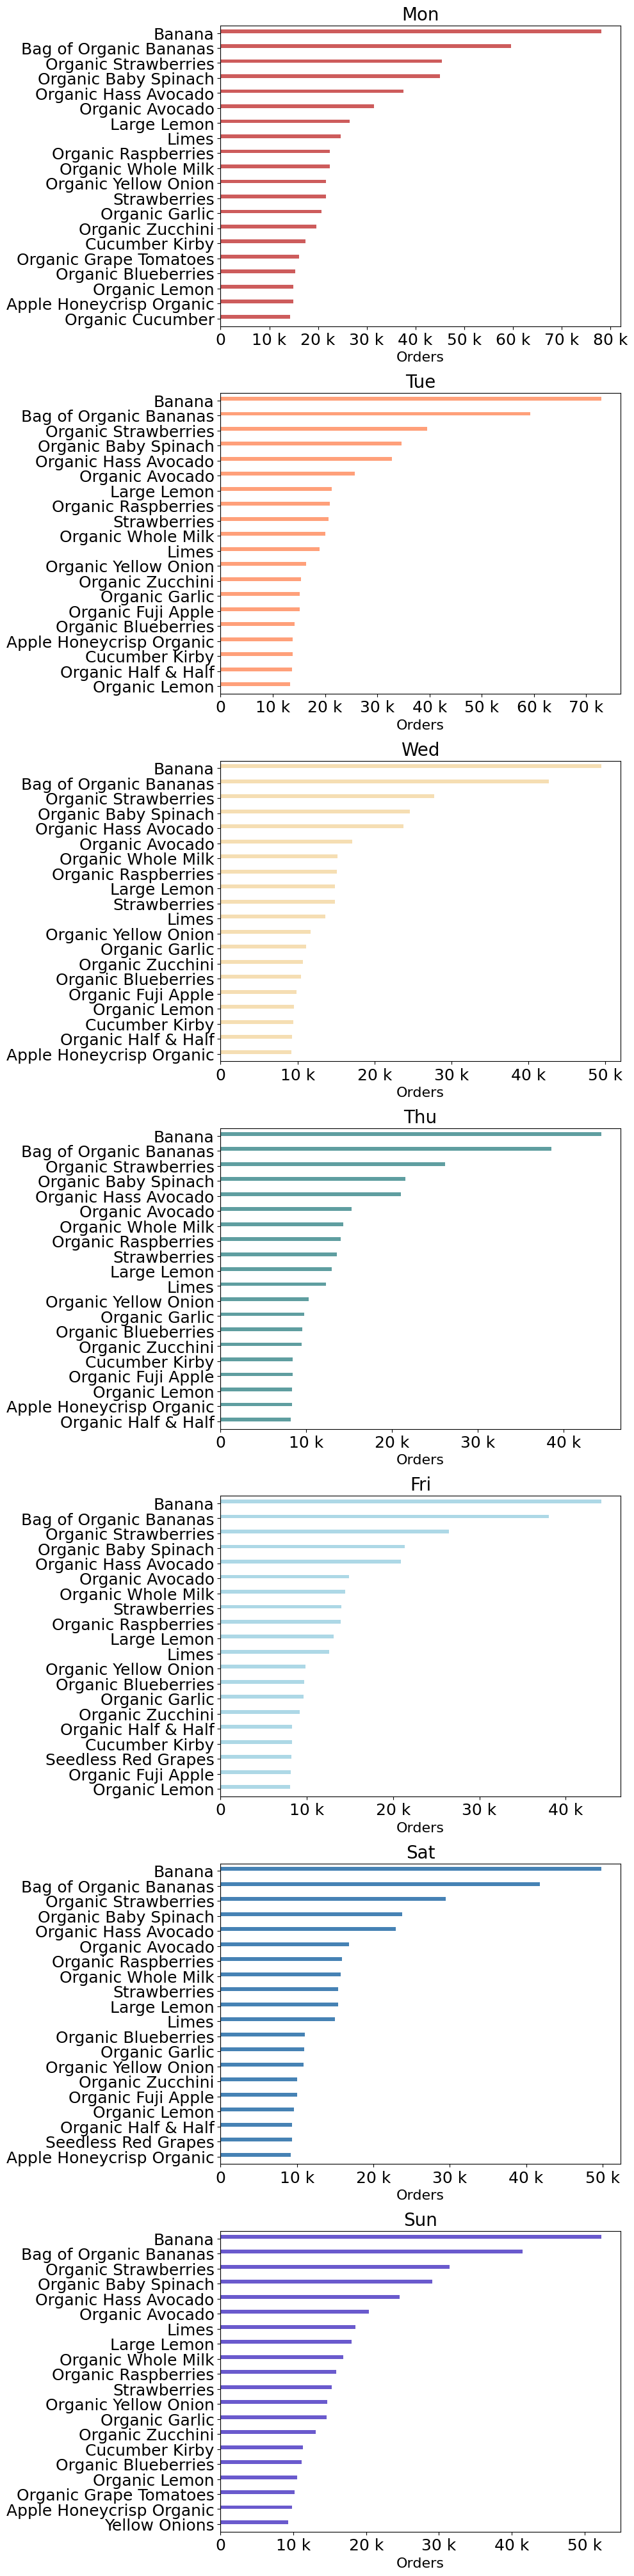

In [63]:
#Изобразим всё в виде столбчатых диаграмм:
dw_colors = ['indianred','lightsalmon','wheat','cadetblue','lightblue','steelblue','slateblue']
fig,axes = plt.subplots(7,1, sharex=False, squeeze=False, figsize=(10,40))
#Возьмем топ-20 продуктов по каждому дню недели:
for ax,q, c in zip(axes.ravel(), prod_dow.dow.unique(), dw_colors):
    tmp_df = prod_dow[prod_dow.dow.eq(q)]\
                .dropna()\
                .sort_values(by='orders_cnt')[-20:]
    ax.set_title(dow_dict.get(q), fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    b = tmp_df.plot.barh(x='product', ax=ax, legend=None, fontsize=18, color = c)
    b.set_xlabel("Orders",fontsize=16)
    b.set_ylabel("Product",fontsize=16)
    b.set_yticklabels((item.get_text()[:25] + '...') if len(item.get_text())>=25 else item.get_text() for item in b.get_yticklabels())
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

*Промежуточный вывод:* Здесь тоже всё достаточно стабильно, список продуктов во все дни практически одинаков, явных закономерностей в данных нет. Не вижу смысла проделывать то же самое по времени покупки (order_hour_of_day) - скорее всего, закономерностей так же не обнаружится.

In [64]:
# Изучим распределение значений в столбце "add_to_cart_order"
ord_len = main[['order_id','add_to_cart_order']].groupby(['order_id'], as_index=False)['add_to_cart_order'].max()
ord_len['add_to_cart_order'].describe(percentiles=[.25, .5, .75, .90]).apply("{0:.5f}".format)

count    2603672.00000
mean          10.14263
std            7.52636
min            1.00000
25%            5.00000
50%            8.00000
75%           14.00000
90%           20.00000
max          145.00000
Name: add_to_cart_order, dtype: object

In [65]:
#Соберем их в группы для визуализации:
def group_ords(x):
    if 1 < x <=5:
        y = '1-5'
    elif 5 < x <= 10:
        y = '6-10'   
    elif 10 < x <= 15:
        y = '11-15' 
    elif 15 < x <= 20:
        y = '16-20'  
    else:
        y = '>20'
    return y
ord_len['len_group'] = ord_len['add_to_cart_order'].apply(group_ords)
ord_len = ord_len.groupby(['len_group'])['order_id'].nunique()
ord_len = ord_len.reindex(['1-5','6-10','11-15','16-20','>20']).reset_index()

In [66]:
#Посмотрим что получилось:
ord_len

len_group  order_id
0       1-5    680920
1      6-10    816985
2     11-15    480345
3     16-20    258731
4       >20    366691

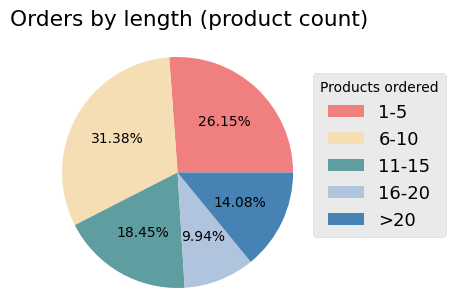

In [67]:
with plt.style.context(['ggplot','seaborn-v0_8-talk']):

    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(ord_len.order_id, autopct='%1.2f%%', labeldistance=1.1, radius=1.25, \
                                  colors = ['lightcoral','wheat','cadetblue','lightsteelblue','steelblue']
                                )
    ax.set_title('Orders by length (product count)', x=0.55, y=1.1)
    ax.legend(wedges,
              ord_len.len_group,
              title="Products ordered",
              bbox_to_anchor=(1.2, 0.22, 0.5, 0.75))
plt.show() 

## Popularity based recsys

In [68]:
#Напишем функцию для получения популярной рекомендации:
def get_popularity_rec(df, n=10, user_treshold = 50):
    #То же, что делали выше:
    df = df[df.groupby('product_id')['user_id'].transform('nunique') > user_treshold]
    popularity = df.groupby('product_id')['reordered'].sum().reset_index()
    popularity.sort_values('reordered', ascending=False, inplace=True)
    res = list(popularity.head(n).product_id)
    return res

Подобная модель предназначена в первую очередь для решения проблемы "холодного старта", поэтому на нашем сете она на покажет хорошего результата (для всех пользователей заказ не первый). В нашем случае нужна модель посерьезнее. Тем не менее, ничего не мешает использовать её для "обрезки" данных - удаления наименее популярных продуктов, что мы делать не будем, посколько это удаляет часть пользователей из набора данных (проверено).

In [69]:
#Разделим данные на train и testset. Мне показалось логичным  в test отправить данные последнего заказа каждого пользователя.
testset = main[main.groupby('user_id')['order_number'].transform('max') == main['order_number']]
trainset = main[main.groupby('user_id')['order_number'].transform('max') != main['order_number']]
set_len = trainset.shape[0] + testset.shape[0]
print('\n К-во строк в тренировочном сете: ', trainset.shape[0], '\n','В тестовом сете ', testset.shape[0])
print('\n В процентом соотношении: ', round(100*(trainset.shape[0]/set_len),1), '% к ', 
      round(100*(testset.shape[0]/set_len),1), '%')


 К-во строк в тренировочном сете:  25328932 
 В тестовом сете  1079141

 В процентом соотношении:  95.9 % к  4.1 %


In [70]:
#Сохраним получившийся testset (далее понадобится):
testset.to_csv('./data/recsys/old_test.csv', sep='\t', index=False)

In [71]:
#Соберем все id продуктов из testset в один столбец - fact_order:
result = testset.groupby('user_id')['product_id'].unique().reset_index()
result.columns=['user_id','fact_order']
#Обрезка до 10 первых продуктов:
result['fact_order'] = result['fact_order'].apply(lambda x: x[:10])
#Проверка
result.head(15)

user_id                                         fact_order
0         1  [196, 46149, 39657, 38928, 25133, 10258, 35951...
1         2  [24852, 16589, 1559, 19156, 18523, 22825, 2741...
2         3                [39190, 47766, 21903, 43961, 17668]
3         7  [47272, 29993, 31683, 27690, 9598, 13198, 3039...
4        13  [27435, 27086, 4210, 43086, 34382, 41926, 1419...
5        14  [39399, 29509, 23803, 15869, 8744, 37266, 1113...
6        15                                       [196, 48142]
7        17  [7350, 18534, 9006, 26767, 14146, 16797, 18567...
8        21  [25740, 6576, 17982, 25513, 8214, 18523, 24799...
9        22                        [35221, 24964, 7948, 24506]
10       24                                            [31222]
11       26         [44632, 30592, 10339, 14947, 31615, 23377]
12       27  [16290, 14766, 14086, 5496, 46676, 33754, 4957...
13       28          [14950, 26128, 42557, 24852, 47209, 5973]
14       29  [39170, 6128, 35385, 33945, 49615, 39803, 2030...

In [72]:
#Посмотрим на простое количество вхождений top-10 продуктов в testset:
pop_recs = get_popularity_rec(main, n = 10)
occurence = 0
df_part = result.sample(15)
for user in df_part.user_id.unique():
    u_array = df_part[df_part.user_id == user]['fact_order'].values.tolist()
    occurence+= sum(np.in1d(pop_recs,u_array))
print('Найдено ', occurence, "совпадений")

Найдено  7 совпадений


Достаточно большое количество сопадений с учетом того, что мы взяли всего 15 пробных строк.

## Вычисление рейтинга товара, итоговые train и test наборы данных

К построению рекомендательной системы можно подойти с разных сторон. Можно подавать данные в неизменном виде, можно убрать часть из них (подать только некоторые признаки, которые кажутся более значимыми или только самые популярные продукты и т.д.), а можно в качестве входных данных подать некий рейтинг, представляющий собой своеобразный коэфиициент значимости данного продукта для конкретного пользователя. 

На уроках все примеры были показаны на последнем варианте, в то время как в текущих данных такого коэффициента нет. Конечно, вместо него можно было бы использовать какой-либо другой признак - тот же простой порядок покупки (add_to_cart_order), но это даст не совсем точный результат, т.к. мы потеряем часть важной информации, котрую можно было бы использовать для предсказания. Поэтому попробуем помучиться и вывести свой рейтинг на основе комбинации имеющихся данных.

Итак, после изучения всех данных у меня сложилось впечатление, что для предсказания важны следующие факторы:
1) количество покупок того или иного продукта в разрезе пользователей (чем больше продукт встречается в покупках, тем лучше);
2) количество повторных покупок того или иного продукта в разрезе пользователей (сумма reordered -  чем больше повторных покупок, тем лучше);
3) очередность покупки того или иного товара (add_to_cart_order - чем раньше, тем вес продукта должен быть выше для пользователя, основной показатель);
4) номер заказа для пользователя (order_number - первые несколько заказов пользователя дают не настолько точную картину, как последующие, что обязательно стоит учесть).

Показатели, которые учитывают дату и время покупки (dow, hour_of_day) не настолько сильно влияют на картину покупок, чтобы это было заметно на графиках, которые были построены в предыдущей части работы.

Показатель к-ва дней между покупками можно было бы использовать для вычисления периодичности пополнения пользователем тех или иных запасов. В то же время периодичность покупки может быть достаточно хаотичной, в случае чего включение данного показателя в вычисление рейтинга может негативно повлиять на точность предсказания. Поэтому для начала попробуем построить рейтинг только на вышеперечисленном.

Категория и подкатегория продукта в принципе может влиять на предсказание - например, при покупке хозяйственного товара логично рекомендовать тоже хозяйственный товар. Изучение данных при этом показало, что большая часть купленного товара при этом относится к двум-трем основным категориям и подкатегориям. В этой связи, как мне кажется, включать в индикатор/рейтинг данные о категории нелогично. Такую информацию лучше использовать для "обрезки" данных, если такая потребуется (оставить только самые популярные категории, убрать наименее окупаемые и т.д.), но попробуем обойтись без неё.

Итак, рейтинг будем строить с учетом показателей из списка выше, при этом, поскольку показатели суммы заказов и повторных заказов слишком связаны между собой, в качестве основного показателя популярности возьмем именно сумму перезаказов. 

In [73]:
#Отрежем нужные нам столбцы из trainset:
main_sub = trainset[['order_id', 'user_id', 'order_number','product_id', 'add_to_cart_order','reordered']]

Создадим отдельный столбец с коэффициентом номера заказа для каждого пользователя. Напомню, что это нужно, чтобы в итоге получить более репрезентативные данные - на ранних стадиях пользования сервисом человек только знакомится с продуктовым набором, поэтому его покупки скорее хаотичны, чем имеют какую-то тенденцию. Кроме того, предпочтения со временем могут поменяться, что также стоит учесть. Чтобы нивелировать эту хаотичность присовим всем покупкам коэффициент номера покупки в виде:

${log_{10} x + 1} $, где x - номер заказа. Таким образом мы добъемся плавного увеличения веса конкретного товара в зависимости от увеличения номера покупки - более "свежий" заказ получит чуть больший вес.

In [74]:
#Учтем номер заказа, посчитав соответсвующий коэффициент
main_sub['order_num_coef'] = main_sub['order_number'].apply(lambda x: round((np.log10(x) + 1),2))

/tmp/ipykernel_218143/1735366462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sub['order_num_coef'] = main_sub['order_number'].apply(lambda x: round((np.log10(x) + 1),2))


Разберемся с учетом данных по порядку добавления в корзину ("add_to_cart_order").

По логике, чем раньше выбран продукт, тем его порядковый вес должен быть больше. Поэтому попросту "перевернем" все значения и отсечем всё, что было после 10-й позиции, как нерелевантное. Формула элементарна:

${(x_{max}+1) - x}$

Т.е. едля первой коэффициент будет 10 (11-1), для второй - 9 (11-2), для третьей - 8 (11-3). Для 10-й позиции, соответственно вес станет 1, а всё последующее попросту удалим.

In [75]:
#Вычислим искомый коэффициент:
main_sub['add_to_cart_coef'] = 11-main_sub['add_to_cart_order']
#Удалим значения ниже единицы, т.е. позиции 11 и дальше:
main_sub= main_sub[main_sub.add_to_cart_coef > 0]
#Check
main_sub.head(15)

/tmp/ipykernel_218143/1662911974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sub['add_to_cart_coef'] = 11-main_sub['add_to_cart_order']


order_id  user_id  order_number  product_id  add_to_cart_order  reordered  \
0    2539329        1             1         196                1.0        0.0   
1    2539329        1             1       14084                2.0        0.0   
2    2539329        1             1       12427                3.0        0.0   
3    2539329        1             1       26088                4.0        0.0   
4    2539329        1             1       26405                5.0        0.0   
5    2398795        1             2         196                1.0        1.0   
6    2398795        1             2       10258                2.0        0.0   
7    2398795        1             2       12427                3.0        1.0   
8    2398795        1             2       13176                4.0        0.0   
9    2398795        1             2       26088                5.0        1.0   
10   2398795        1             2       13032                6.0        0.0   
11    473747        1             3         196                1.0        1.0   
12    473747        1             3       12427                2.0        1.0   
13    473747        1             3       10258                3.0        1.0   
14    473747        1             3       25133                4.0        0.0   

    order_num_coef  add_to_cart_coef  
0             1.00              10.0  
1             1.00               9.0  
2             1.00               8.0  
3             1.00               7.0  
4             1.00               6.0  
5             1.30              10.0  
6             1.30               9.0  
7             1.30               8.0  
8             1.30               7.0  
9             1.30               6.0  
10            1.30               5.0  
11            1.48              10.0  
12            1.48               9.0  
13            1.48               8.0  
14            1.48               7.0

In [76]:
#Теперь скоректируем его с учетом номера заказа:
main_sub['add_to_cart_coef'] = main_sub['add_to_cart_coef'] * main_sub['order_num_coef']
#Le check
main_sub.head(15)

order_id  user_id  order_number  product_id  add_to_cart_order  reordered  \
0    2539329        1             1         196                1.0        0.0   
1    2539329        1             1       14084                2.0        0.0   
2    2539329        1             1       12427                3.0        0.0   
3    2539329        1             1       26088                4.0        0.0   
4    2539329        1             1       26405                5.0        0.0   
5    2398795        1             2         196                1.0        1.0   
6    2398795        1             2       10258                2.0        0.0   
7    2398795        1             2       12427                3.0        1.0   
8    2398795        1             2       13176                4.0        0.0   
9    2398795        1             2       26088                5.0        1.0   
10   2398795        1             2       13032                6.0        0.0   
11    473747        1             3         196                1.0        1.0   
12    473747        1             3       12427                2.0        1.0   
13    473747        1             3       10258                3.0        1.0   
14    473747        1             3       25133                4.0        0.0   

    order_num_coef  add_to_cart_coef  
0             1.00             10.00  
1             1.00              9.00  
2             1.00              8.00  
3             1.00              7.00  
4             1.00              6.00  
5             1.30             13.00  
6             1.30             11.70  
7             1.30             10.40  
8             1.30              9.10  
9             1.30              7.80  
10            1.30              6.50  
11            1.48             14.80  
12            1.48             13.32  
13            1.48             11.84  
14            1.48             10.36

In [77]:
#Посчитаем коэффициент перезаказов c учетом add_to_cart_coef:
main_sub['reordered'] = main_sub['reordered'] * main_sub['add_to_cart_coef']
#Le check
main_sub.head(15)

order_id  user_id  order_number  product_id  add_to_cart_order  reordered  \
0    2539329        1             1         196                1.0       0.00   
1    2539329        1             1       14084                2.0       0.00   
2    2539329        1             1       12427                3.0       0.00   
3    2539329        1             1       26088                4.0       0.00   
4    2539329        1             1       26405                5.0       0.00   
5    2398795        1             2         196                1.0      13.00   
6    2398795        1             2       10258                2.0       0.00   
7    2398795        1             2       12427                3.0      10.40   
8    2398795        1             2       13176                4.0       0.00   
9    2398795        1             2       26088                5.0       7.80   
10   2398795        1             2       13032                6.0       0.00   
11    473747        1             3         196                1.0      14.80   
12    473747        1             3       12427                2.0      13.32   
13    473747        1             3       10258                3.0      11.84   
14    473747        1             3       25133                4.0       0.00   

    order_num_coef  add_to_cart_coef  
0             1.00             10.00  
1             1.00              9.00  
2             1.00              8.00  
3             1.00              7.00  
4             1.00              6.00  
5             1.30             13.00  
6             1.30             11.70  
7             1.30             10.40  
8             1.30              9.10  
9             1.30              7.80  
10            1.30              6.50  
11            1.48             14.80  
12            1.48             13.32  
13            1.48             11.84  
14            1.48             10.36

In [78]:
# Посчитаем рейтинг, как add_to_cart_coef с учетом регулярности покупки продукта покупателем (reordered)
# Доли показателей определим как 0.8 и 0.2 в результирующем соответственно.
main_sub['rating']  = (main_sub.add_to_cart_coef * 0.8) + (main_sub.reordered * 0.2)
#Что получилось в итоге:
main_sub.head(15)

order_id  user_id  order_number  product_id  add_to_cart_order  reordered  \
0    2539329        1             1         196                1.0       0.00   
1    2539329        1             1       14084                2.0       0.00   
2    2539329        1             1       12427                3.0       0.00   
3    2539329        1             1       26088                4.0       0.00   
4    2539329        1             1       26405                5.0       0.00   
5    2398795        1             2         196                1.0      13.00   
6    2398795        1             2       10258                2.0       0.00   
7    2398795        1             2       12427                3.0      10.40   
8    2398795        1             2       13176                4.0       0.00   
9    2398795        1             2       26088                5.0       7.80   
10   2398795        1             2       13032                6.0       0.00   
11    473747        1             3         196                1.0      14.80   
12    473747        1             3       12427                2.0      13.32   
13    473747        1             3       10258                3.0      11.84   
14    473747        1             3       25133                4.0       0.00   

    order_num_coef  add_to_cart_coef  rating  
0             1.00             10.00   8.000  
1             1.00              9.00   7.200  
2             1.00              8.00   6.400  
3             1.00              7.00   5.600  
4             1.00              6.00   4.800  
5             1.30             13.00  13.000  
6             1.30             11.70   9.360  
7             1.30             10.40  10.400  
8             1.30              9.10   7.280  
9             1.30              7.80   7.800  
10            1.30              6.50   5.200  
11            1.48             14.80  14.800  
12            1.48             13.32  13.320  
13            1.48             11.84  11.840  
14            1.48             10.36   8.288

In [79]:
#Сохраним получившееся (далее понадобится):
main_sub.to_csv('./data/recsys/old_train.csv', sep='\t', index=False)

In [80]:
#Теперь уберём информацию о номере заказа, она нам больше не нужна.
#Для этого сгруппируем данные по пользователям и продуктам и просуммируем рейтинг:
coef_df = main_sub.groupby(['user_id','product_id'], as_index = False).agg(rating = ('rating','sum'))
#Check
coef_df.head(15)

user_id  product_id   rating
0         1         196  135.850
1         1       10258  105.390
2         1       10326    8.160
3         1       12427  119.390
4         1       13032   16.300
5         1       13176   12.380
6         1       14084    7.200
7         1       17122    6.800
8         1       25133   85.698
9         1       26088   13.400
10        1       26405   14.400
11        1       30450    7.104
12        1       41787    5.440
13        1       46149   26.670
14        1       49235   27.100

Вот такая информация у нас получилась в итоге по пользователям и продуктам. Рейтинг имеет при этом достаточно большой разброс. Оценим его.

In [81]:
#Посмотрим на распределение значений
coef_df['rating'].describe(percentiles=[.25, .5, .75, .90]).apply("{0:.5f}".format)

count    6863037.00000
mean          32.75621
std           64.63679
min            0.80000
25%            7.60000
50%           14.16000
75%           30.55200
90%           72.70000
max         2384.03000
Name: rating, dtype: object

In [82]:
#Значения меньше одного нерелевантны для нас, поэтому удалим их:
coef_df = coef_df[coef_df.rating > 1]
coef_df['rating'].describe(percentiles=[.25, .5, .75, .90]).apply("{0:.5f}".format)

count    6844161.00000
mean          32.84434
std           64.70404
min            1.04000
25%            7.61600
50%           14.24000
75%           30.64000
90%           72.87800
max         2384.03000
Name: rating, dtype: object

Такое распределение для использования библиотеки surprise не совсем подходит. Приведем его к приемлимому диапазону от 1 до 10.

In [83]:
autoscaler = MinMaxScaler(feature_range = (1,10))
def sc(row):
    return autoscaler.fit_transform(row.values.reshape(-1,1))
coef_df['scaled'] = coef_df.groupby('user_id')['rating'].apply(sc).explode().values.astype(float)

/tmp/ipykernel_218143/1818136804.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef_df['scaled'] = coef_df.groupby('user_id')['rating'].apply(sc).explode().values.astype(float)


In [84]:
#Check
coef_df.head(15)

user_id  product_id   rating     scaled
0         1         196  135.850  10.000000
1         1       10258  105.390   7.897861
2         1       10326    8.160   1.187716
3         1       12427  119.390   8.864044
4         1       13032   16.300   1.749482
5         1       13176   12.380   1.478951
6         1       14084    7.200   1.121463
7         1       17122    6.800   1.093858
8         1       25133   85.698   6.538854
9         1       26088   13.400   1.549344
10        1       26405   14.400   1.618357
11        1       30450    7.104   1.114838
12        1       41787    5.440   1.000000
13        1       46149   26.670   2.465148
14        1       49235   27.100   2.494824

In [85]:
#Завершающие штрихи:
coef_df.drop(columns = ['rating'], inplace = True)
coef_df.rename(columns={"scaled": "rating"}, inplace = True)
coef_df['rating'] = coef_df['rating'].astype(np.float16)
coef_df.head(15)

user_id  product_id     rating
0         1         196  10.000000
1         1       10258   7.898438
2         1       10326   1.187500
3         1       12427   8.867188
4         1       13032   1.749023
5         1       13176   1.478516
6         1       14084   1.121094
7         1       17122   1.093750
8         1       25133   6.539062
9         1       26088   1.549805
10        1       26405   1.618164
11        1       30450   1.115234
12        1       41787   1.000000
13        1       46149   2.464844
14        1       49235   2.494141

In [86]:
#Сохраним, чтобы пользоваться df из загруженного файла и не перезапускать постоянно долго соображающий код:
coef_df.to_csv('./data/recsys/train_df.csv', sep='\t', index=False, header = False)

In [87]:
#Также обработаем testset:
test_df = testset[["user_id","product_id","add_to_cart_order"]]
#Вычислим рейтинг простейшим образом - "перевернем" порядок покупок, т.е. первому продукту присвоим рейтинг 10, второму 9 и т.д.
test_df['rating'] = (11-test_df['add_to_cart_order'])
#удалим лишнее:
test_df.drop(columns = ['add_to_cart_order'], inplace = True)
test_df['rating'] = test_df['rating'].astype(np.float16)
#Check
test_df.head(15)

/tmp/ipykernel_218143/1782498337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['rating'] = (11-test_df['add_to_cart_order'])
/tmp/ipykernel_218143/1782498337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns = ['add_to_cart_order'], inplace = True)
/tmp/ipykernel_218143/1782498337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

user_id  product_id  rating
50         1         196    10.0
51         1       46149     9.0
52         1       39657     8.0
53         1       38928     7.0
54         1       25133     6.0
55         1       10258     5.0
56         1       35951     4.0
57         1       13032     3.0
58         1       12427     2.0
238        2       24852    10.0
239        2       16589     9.0
240        2        1559     8.0
241        2       19156     7.0
242        2       18523     6.0
243        2       22825     5.0

In [88]:
#Также сохраним:
test_df.to_csv('./data/recsys/test_df.csv',sep='\t', index=False, header = False)

## Кросс-валидация и выбор модели

In [2]:
#Для кросс-валидации загрузим из файла coef_df:
data_dir = './data/recsys/'

TRAIN_CSV_PATH = os.path.join(data_dir, 'train_df.csv')

coef_df = pd.read_csv(TRAIN_CSV_PATH, sep='\t')

#Для передачи в модель:

reader = Reader(line_format="user item rating", sep = '\t',rating_scale=(1, 10)) # Зададим разброс оценок
data_coef = Dataset.load_from_df(coef_df, reader=reader) #создадим data-объект

Посмотрим, как показывают себя доступные в библиотеке модели на кросс-валидации. Попробуем все доступные варианты, кроме алгоритмов ближайших соседей (KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore), поскольку количество данных для них слишком большое, а уроезать их до минимума тоже не хочется.

In [3]:
benchmark = []
# Итерация по всем алгоритмам
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), BaselineOnly(), CoClustering()]:
    # Кросс-валидация по алгоритму
    results = cross_validate(algorithm, data_coef, measures=['RMSE'], cv=3, verbose=False, n_jobs = -1)
    
    # Получение результатов и сбор всего в единую таблицу
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)
    
bench_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [4]:
#На всякий сохраним
bench_df.to_csv('./data/recsys/bench_df.csv',sep='\t', index=False)

In [5]:
#Оценим результат
bench_df

test_rmse   fit_time  test_time
Algorithm                                       
BaselineOnly      1.837311   0.606883   3.439238
SlopeOne          1.860573   2.892843  16.527214
SVD               1.948396   8.441773   4.393528
CoClustering      1.949352   7.225754   4.106102
SVDpp             2.065438  86.062126  23.742577
NMF               2.086003  10.379664   3.844085
NormalPredictor   2.571857   0.598317   3.023328

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


Заметно, что лучший результат по RMSE показали (в порядке снижения точности) алгоритмы BaselineOnly (по умолчанию ALS),  SlopeOne и SVD c Coclustering (достаточно близкий результат у обоих вариантов). При этом наименьшее время потребовалось алгоритмам NormalPredictor, BaselineOnly. Алгоритм SlopeOne достаточно быстро обучился, но очень долго делал предсказание. Чуть дольше обучались и делали предсказание модели SVD и CoClustering (снова близкий результат). Дольше всех на всех этапах работает SVDpp.

Попробуем немного поиграть с параметрами лучших моделей и выявим наилучший вариант.

In [3]:
#Сравним методы ALS и SGD из коробки:
opts1 = {'method': 'als', "verbose":"False"}
opts2 = {'method': 'sgd', "verbose":"False"}
bench_bo =[]
for opts in [opts1,opts2]:
    algo = BaselineOnly(bsl_options = opts)
    cv=cross_validate(algo, data_coef, measures=['RMSE'], cv=3, verbose=False, n_jobs = -1)
     # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(cv).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(opts.get("method"))], index=['Algorithm'])])
    bench_bo.append(tmp)
pd.DataFrame(bench_bo).set_index('Algorithm').sort_values('test_rmse') 

test_rmse  fit_time  test_time
Algorithm                                
als         1.837290  0.595222   3.531146
sgd         1.852192  1.523484   3.404243

In [4]:
#Попробуем разные параметры для ALS:
epochs = [5,10,15,20]
u_list = [14,15,16,17,18]
i_list = [4,5,6,7,8,9,10]
best_score = 2
best_opts = None
for ep in epochs:
    for u in u_list:
        for i in i_list:
            bsl_options = {"method": "als", "n_epochs": ep, "reg_u": u,  "reg_i": i}
            algo = BaselineOnly(bsl_options = bsl_options)
            cv=cross_validate(algo, data_coef, measures=['RMSE'], cv=3, verbose=False)
            curr_score = np.mean(cv['test_rmse'])
            if curr_score < best_score:
                best_score = curr_score
                best_opts = str(bsl_options)   
print('Best mean RMSE =', best_score, 'for option: ', best_opts)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [7]:
#Для SVD - метода:
best_score = 2
best_opts = None
for i in [1,5,10,15,20,25,50,75,125,150]:
    algo = SVD(n_factors=i,random_state=999, verbose=False) #отключим вывод логирования
    cv=cross_validate(algo, data_coef, measures=['RMSE'], cv=3, verbose=False)
    if curr_score < best_score:
        best_score = curr_score
        best_opts = str(i)
print('Best mean RMSE =', best_score, ' for SVD with ' ,str(best_opts)+' - factors:')

Best mean RMSE = 1.8372831441294413  for SVD with  1 - factors:


## Обучение модели по методу наименьших квадратов (ALS)

In [2]:
#Для подачи в модели:
files_dir = './data/recsys/'

TRAIN_CSV_PATH = os.path.join(files_dir, 'train_df.csv')
TEST_CSV_PATH = os.path.join(files_dir, 'test_df.csv')

reader = Reader(line_format="user item rating", sep = '\t',rating_scale=(1, 10)) # Зададим разброс оценок

folds_files = [(TRAIN_CSV_PATH,TEST_CSV_PATH)] #список путей к файлам для подачи в объект библиотеки surprise lib
data = Dataset.load_from_folds(folds_files, reader=reader) #создадим data-объект

pkf = PredefinedKFold() #создадим объект, позволяющий подать в модель собственный набор train и test данных
trainset, testset = next(pkf.split(data)) #определим train и test сеты

In [3]:
#Установим модель с лучшим результатом:
bsl_options =  {'method': 'als', 'n_epochs': 20, 'reg_u': 18, 'reg_i': 6}
algo = BaselineOnly(bsl_options = bsl_options)

In [4]:
%%time
#Сделаем предсказание:
predictions = algo.fit(trainset).test(testset)

Estimating biases using als...
CPU times: user 12.3 s, sys: 3.61 ms, total: 12.3 s
Wall time: 12.3 s


In [5]:
#Соберем в сет:
appended_data = []
for i in predictions:
    appended_data.append(i)
pred_df = pd.DataFrame(appended_data, columns = ['user_id','product_id','real_rating','predicted_rating','details'])
pred_df.drop(columns = ["details"], inplace = True)

In [6]:
pred_df.head(15)

user_id product_id  real_rating  predicted_rating
0        1        196         10.0          4.170846
1        1      46149          9.0          4.080973
2        1      39657          8.0          3.351688
3        1      38928          7.0          4.115123
4        1      25133          6.0          2.929239
5        1      10258          5.0          2.933067
6        1      35951          4.0          3.407510
7        1      13032          3.0          2.488235
8        1      12427          2.0          3.196634
9        2      24852         10.0          4.943528
10       2      16589          9.0          2.356979
11       2       1559          8.0          2.376852
12       2      19156          7.0          2.121500
13       2      18523          6.0          2.584406
14       2      22825          5.0          1.921481

In [7]:
pred_df["user_id"] = pred_df.user_id.astype(np.int32)
#Теперь нам нужно правильно отсортировать предсказание по столбцу с предполагаемым рейтингом, обрезав его до 10 значений:
pred_grouped = pred_df.merge(pred_df
        #Сгруппируем по пользователям, найдем 10 макс значений предсказанного рейтинга
        .groupby('user_id').predicted_rating.nlargest(10)
        #Получим новый df с  MultiIndex, котрый сбросим через reset_index
        .reset_index('user_id'),
        # в новом df нет колонки "product_id" поэтому необходимо объединить изначальный сет с полученным
    how='right') # при этом все строки, которых нет в новом df удалятся
#Проверка
pred_grouped.head(15)

user_id product_id  real_rating  predicted_rating
0         1        196         10.0          4.170846
1         1      38928          7.0          4.115123
2         1      46149          9.0          4.080973
3         1      35951          4.0          3.407510
4         1      39657          8.0          3.351688
5         1      12427          2.0          3.196634
6         1      10258          5.0          2.933067
7         1      25133          6.0          2.929239
8         1      13032          3.0          2.488235
9         2      24852         10.0          4.943528
10        2      47209          1.0          3.145159
11        2      21709          2.0          2.923533
12        2      33754          3.0          2.608391
13        2      18523          6.0          2.584406
14        2       1559          8.0          2.376852

In [8]:
#Соберем все id продуктов в один столбец - pred_order:
pred_result = pred_grouped.groupby('user_id')['product_id'].unique().reset_index()
pred_result.columns=['user_id','pred_order']
#Check
pred_result.head(15)

user_id                                         pred_order
0         1  [196, 38928, 46149, 35951, 39657, 12427, 10258...
1         2  [24852, 47209, 21709, 33754, 18523, 1559, 7781...
2         3                [47766, 21903, 39190, 17668, 43961]
3         7  [40852, 21137, 37602, 47272, 31683, 30391, 276...
4        13  [4210, 27086, 27435, 43086, 41926, 42248, 1419...
5        14  [29509, 15172, 15869, 23803, 38845, 37266, 874...
6        15                                       [196, 48142]
7        17  [14146, 7350, 18534, 16797, 48933, 9006, 26767...
8        21  [49235, 18523, 28465, 32645, 28204, 17982, 247...
9        22                        [35221, 24964, 7948, 24506]
10       24                                            [31222]
11       26         [14947, 44632, 10339, 31615, 30592, 23377]
12       27  [35958, 27966, 21137, 33754, 18523, 5496, 3378...
13       28          [24852, 47209, 26128, 14950, 42557, 5973]
14       29  [49615, 20305, 6128, 39170, 33945, 16953, 1920...

In [9]:
#Таким же образом соберем факт:
fact_df = pred_df.merge(pred_df
        #Сгруппируем по пользователям, найдем 10 макс значений предсказанного рейтинга
        .groupby('user_id').real_rating.nlargest(10)
        #Получим новый df с  MultiIndex, котрый сбросим через reset_index
        .reset_index('user_id'),
        # в новом df нет колонки "product_id" поэтому необходимо объединить изначальный сет с полученным
    how='right') # при этом все строки, которых нет в новом df удалятся
#Проверка
fact_df.head(15)

user_id product_id  real_rating  predicted_rating
0         1        196         10.0          4.170846
1         1      46149          9.0          4.080973
2         1      39657          8.0          3.351688
3         1      38928          7.0          4.115123
4         1      25133          6.0          2.929239
5         1      10258          5.0          2.933067
6         1      35951          4.0          3.407510
7         1      13032          3.0          2.488235
8         1      12427          2.0          3.196634
9         2      24852         10.0          4.943528
10        2      16589          9.0          2.356979
11        2       1559          8.0          2.376852
12        2      19156          7.0          2.121500
13        2      18523          6.0          2.584406
14        2      22825          5.0          1.921481

In [10]:
fact_df = fact_df.groupby('user_id')['product_id'].unique().reset_index()
fact_df.columns=['user_id','fact_order']
#Check
fact_df.head(15)

user_id                                         fact_order
0         1  [196, 46149, 39657, 38928, 25133, 10258, 35951...
1         2  [24852, 16589, 1559, 19156, 18523, 22825, 2741...
2         3                [39190, 47766, 21903, 43961, 17668]
3         7  [47272, 29993, 31683, 27690, 9598, 13198, 3039...
4        13  [27435, 27086, 4210, 43086, 34382, 41926, 1419...
5        14  [39399, 29509, 23803, 15869, 8744, 37266, 1113...
6        15                                       [196, 48142]
7        17  [7350, 18534, 9006, 26767, 14146, 16797, 18567...
8        21  [25740, 6576, 17982, 25513, 8214, 18523, 24799...
9        22                        [35221, 24964, 7948, 24506]
10       24                                            [31222]
11       26         [44632, 30592, 10339, 14947, 31615, 23377]
12       27  [16290, 14766, 14086, 5496, 46676, 33754, 4957...
13       28          [14950, 26128, 42557, 24852, 47209, 5973]
14       29  [39170, 6128, 35385, 33945, 49615, 39803, 2030...

In [11]:
result = fact_df.merge(pred_result, how = 'left')
result.head()

user_id                                         fact_order  \
0        1  [196, 46149, 39657, 38928, 25133, 10258, 35951...   
1        2  [24852, 16589, 1559, 19156, 18523, 22825, 2741...   
2        3                [39190, 47766, 21903, 43961, 17668]   
3        7  [47272, 29993, 31683, 27690, 9598, 13198, 3039...   
4       13  [27435, 27086, 4210, 43086, 34382, 41926, 1419...   

                                          pred_order  
0  [196, 38928, 46149, 35951, 39657, 12427, 10258...  
1  [24852, 47209, 21709, 33754, 18523, 1559, 7781...  
2                [47766, 21903, 39190, 17668, 43961]  
3  [40852, 21137, 37602, 47272, 31683, 30391, 276...  
4  [4210, 27086, 27435, 43086, 41926, 42248, 1419...

In [12]:
#Напишем базовую комплектацию показателей для проверки точности вычисления рейтинга моделью.
def Avg_Precision_at_n(fact, predicted, n=10):
    """
    Вычисление средней точности по n-позициям для двух списков значений.
    
    Вход
    ----------
    fact : list
             Фактический список элементов, который нужно предсказать.
    predicted : list
             Список, полученный в результате предсказания модели (строго упорядоченный).
    n : int
             Максимальное количество предсказываемых позиций
    Выход
    -------
    score : double
            Средняя точность на n-позициях
    """
    if not fact:
        return 0.0

    if len(predicted)>n:
        predicted = predicted[:n]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # Первое условие проверяет наличие предсказания в списке фактических элементов
        # второе условие - проверка на отсутствие (или наличие) повторов в предсказании
        if p in fact and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(fact), n)

def MAP_at_n(fact, predicted, n=10):
    """
    Вычисление mean average precision at n для двух списков элементов.
   
    Вход
    ----------
    fact : list
            Фактический список элементов, который нужно предсказать.
    predicted : list
            Список, полученный в результате предсказания модели (строго упорядоченный).
    n : int
            Максимальное количество предсказываемых позиций
    Выход
    -------
    score : double
            Mean average precision at n двух списков
    """
    return np.mean([Avg_Precision_at_n(f,p,n) for f,p in zip(fact, predicted)])

In [13]:
#Применим функцию MAP_at_n построчно:
result['MAP'] = result.apply(lambda x: MAP_at_n(x.fact_order, x.pred_order), axis=1)

In [14]:
result.head()

user_id                                         fact_order  \
0        1  [196, 46149, 39657, 38928, 25133, 10258, 35951...   
1        2  [24852, 16589, 1559, 19156, 18523, 22825, 2741...   
2        3                [39190, 47766, 21903, 43961, 17668]   
3        7  [47272, 29993, 31683, 27690, 9598, 13198, 3039...   
4       13  [27435, 27086, 4210, 43086, 34382, 41926, 1419...   

                                          pred_order       MAP  
0  [196, 38928, 46149, 35951, 39657, 12427, 10258...  0.371481  
1  [24852, 47209, 21709, 33754, 18523, 1559, 7781...  0.318167  
2                [47766, 21903, 39190, 17668, 43961]  0.244667  
3  [40852, 21137, 37602, 47272, 31683, 30391, 276...  0.233917  
4  [4210, 27086, 27435, 43086, 41926, 42248, 1419...  0.568333

In [15]:
sum(result.MAP)/len(result.user_id.unique())

0.35594537635030166

Если я всё правильно рассчитала, то получается достаточно неплохой результат.

In [16]:
#Проверим точность на этом предсказании в Kaggle:
prediction_df = pred_grouped.groupby('user_id')['product_id'].agg(' '.join).reset_index(name='product_id')
#Cохраним
prediction_df.to_csv('./data/recsys/prediction_df.csv',sep=',', index=False)

На данном предсказании получается точность выше зачетного минимума - 0.22968 (private score), что уже позволяет сдать работу "as is", но мы попробуем еще помучиться немного и повысить точность.